<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM%20-%20Full%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup ##

In [ ]:
'''
Platform specific code to pull github code into colab and vice versa
'''

import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 636, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 636 (delta 66), reused 178 (delta 24), pack-reused 398 (from 1)
Receiving objects: 100% (636/636), 314.65 MiB | 43.33 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Updating files: 100% (78/78), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron




### Imports ###

In [ ]:
# import optuna package for hyperparameter optimisation
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
## collect project imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# convert data into pandas dataframe, check basic structure
test_df = pd.read_csv('../../data/processed/processed_full.csv')
test_df

(3652, 38)

In [ ]:
# convert date_time into correct format and set as index, as datetime will not
# be used in feature set
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%d/%m/%Y')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2010-01-01           1          0          0          0          0          0   
2010-01-02           1          0          0          0          0          0   
2010-01-03           1          0          0          0          1          0   
2010-01-04           1          0          0          0          0          1   
2010-01-05           1          0          0          0          0          0   
2010-01-06           1          0          0          0          0          0   
2010-01-07           1          0          0          0          0          0   
2010-01-08           1          0          0          0          0          0   
2010-01-09           1          0          0          0          0          0   
2010-01-10           1          0          0          0          1          0   
2010-01-11           1          0          0          0          0          1   
2010-01-12           1          0          0          0          0          0   
2010-01-13           1          0          0          0          0          0   
2010-01-14           1          0          0          0          0          0   
2010-01-15           1          0          0          0          0          0   
2010-01-16           1          0          0          0          0          0   
2010-01-17           1          0          0          0          1          0   
2010-01-18           1          0          0          0          0          1   
2010-01-19           1          0          0          0          0          0   
2010-01-20           1          0          0          0          0          0   
2010-01-21           1          0          0          0          0          0   
2010-01-22           1          0          0          0          0          0   
2010-01-23           1          0          0          0          0          0   
2010-01-24           1          0          0          0          1          0   
2010-01-25           1          0          0          0          0          1   
2010-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2010-01-01            0             0            0          1  ...   
2010-01-02            0             0            0          0  ...   
2010-01-03            0             0            0          0  ...   
2010-01-04            0             0            0          0  ...   
2010-01-05            1             0            0          0  ...   
2010-01-06            0             1            0          0  ...   
2010-01-07            0             0            1          0  ...   
2010-01-08            0             0            0          1  ...   
2010-01-09            0             0            0          0  ...   
2010-01-10            0             0            0          0  ...   
2010-01-11            0             0            0          0  ...   
2010-01-12            1             0            0          0  ...   
2010-01-13            0             1            0          0  ...   
2010-01-14            0             0            1          0  ...   
2010-01-15            0             0            0          1  ...   
2010-01-16            0             0            0          0  ...   
2010-01-17            0             0            0          0  ...   
2010-01-18            0             0            0          0  ...   
2010-01-19            1             0            0          0  ...   
2010-01-20            0             1            0          0  ...   
2010-01-21            0             0            1          0  ...   
2010-01-22            0             0            0          1  ...   
2010-01-23            0             0            0          0  .

### Helper Functions ###

In [ ]:
'''
Set up multiple versions of data processor.  Function scales data into a MinMax form
suitable for LSTM model, sets up a data lag window based on window size and creates
train test splits (with an optional validation set for early model runs)

- Note different train/(val)/test splits due to longer time series
'''
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    # returns data for a specified year
    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    # as above, but adds data from previous year to account for lost data due
    # to window size selection
    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    # splits data based on 60:20:20 split, and accounts for overlap choice
    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1]), self._get_year_slice(years[2]), self._get_year_slice(years[3]), self._get_year_slice(years[4]), self._get_year_slice(years[5]), self._get_year_slice(years[6])])
            val_df = pd.concat([self._get_extended_slice(years[7], years[6]), self._get_extended_slice(years[8], years[7])])
            test_df = self._get_extended_slice(years[9], years[8])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1]), self._get_year_slice(years[2]), self._get_year_slice(years[3]), self._get_year_slice(years[4]), self._get_year_slice(years[5]), self._get_year_slice(years[6])])
            val_df = pd.concat([self._get_year_slice(years[7]), self._get_year_slice(years[8])])
            test_df = self._get_year_slice(years[9])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    # scales data for LSTM
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    # creates data matrix
    def to_X_and_y(self, df_scaled, target_col='sum_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs

# subclass for exclusion of validation set
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):

    # splits data based on 90:10 train test split
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 9 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2]),
            self._get_year_slice(years[3]),
            self._get_year_slice(years[4]),
            self._get_year_slice(years[5]),
            self._get_year_slice(years[6]),
            self._get_year_slice(years[7]),
            self._get_year_slice(years[8])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[9])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs

# function to reset seed prior to each model run
def reset_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [ ]:
'''
Setup all Optuna Hyperparameter Objective Functions for later use
'''

## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## Tweaked Optuna function for early stopping, etc.

def objective2(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units1 = trial.suggest_int("n_units1", 32, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    stacked = trial.suggest_categorical("stacked", [False, True])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        if stacked:
            model.add(LSTM(n_units1, return_sequences=True, dropout=dropout))
            model.add(LSTM(n_units2, dropout=dropout))
        else:
            model.add(LSTM(n_units1, dropout=dropout))

        model.add(Dense(8, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        checkpoint_path = f"trial_{trial.number}_best.keras"
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                            save_best_only=True, save_weights_only=False, verbose=0)
        ]

        history = model.fit(
            X_train20, y_train20,
            epochs=200,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks,
            verbose=0
        )

        best_model = load_model(checkpoint_path)

        y_pred = best_model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: stacked={stacked}, units1={n_units1}, units2={n_units2}, "
          f"dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

## Optuna Function for CNN=LSTM Hybrid ##

def objective3(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    filters = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    pool_size = trial.suggest_int("pool_size", 2, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        # CNN block
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))

        # LSTM block
        model.add(LSTM(lstm_units, dropout=0.013))

        # Dense head
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Train with validation split for val_loss
        model.fit(
            X_train20, y_train20,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=0
        )

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: filters={filters}, kernel={kernel_size}, pool={pool_size}, "
          f"lstm_units={lstm_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae


## Final Optuna Function - include Recurrent Dropout

def objective4(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train29.shape[1], X_train29.shape[2])),
            layers.LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train29, y_train29, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test29, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

In [ ]:
# function for reuse of basic model creation
def create_lstm_model(n_units=64, dropout=0.0, recurrent_dropout=0.0):

    # Basic LSTM Structure (see Report Section 3.3.2.3.2 Figure 5)
    model = Sequential()
    model.add(InputLayer((i, j)))
    model.add(LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(8, 'tanh'))
    model.add(Dense(1, 'linear'))

    return model

def create_stacked_lstm_model(n_units1=32, n_units2=16, dropout1=0.013, dropout2=0.013):
    # Add second LSTM layer and return_sequences to ensure data is carried through
    model = Sequential()
    model.add(InputLayer((i, j)))
    model.add(LSTM(units = n_units1, dropout=dropout1, return_sequences=True))
    model.add(LSTM(units = n_units2, dropout=dropout2))
    model.add(Dense(8, 'tanh'))
    model.add(Dense(1, 'linear'))

    return model

def create_cnn_lstm_model(filters=64, kernel_size=3, pool_size=2, lstm_units=32, dropout1=0.013, dropout2=0.013):
    # CNN into LSTM structure
    model = Sequential()
    model.add(InputLayer((i, j)))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout1))
    model.add(LSTM(units = lstm_units, dropout=dropout2))
    model.add(Dense(8, 'tanh'))
    model.add(Dense(1, 'linear'))

    return model


## 1. Baseline Model - Sum Demand Only ##

In [ ]:
# Create dataset with single predictor
demandDF = test_df[['sum_30_min_demand']]

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

# Initialise variables for input layer
i = X_train.shape[1]
j = X_train.shape[2]

### Setup function for printing predictions plot and metrics ###

In [ ]:
# Plot prediction function is set up here as it needs an initialised preprocessor
# to define the function

def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='sum_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [ ]:
# set seed
reset_seed

# create model
model1 = create_lstm_model()

# create model checkpoint
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)

# compile model
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

# run model with defined train test validation splits, with associated callbacks
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


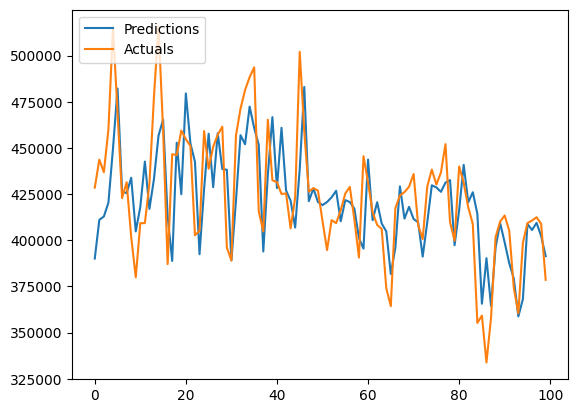

MAPE: 3.60%
RMSE: 18531.62
MAE : 14116.00


Predictions    Actuals
0     390129.03125  428486.93
1     411064.18750  443638.09
2     412892.34375  436849.95
3     420435.96875  460042.56
4     449695.40625  515344.46
...            ...        ...
2545  380328.34375  366570.55
2546  373017.68750  396529.66
2547  390293.25000  430688.95
2548  402851.18750  423274.20
2549  384373.65625  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model1 = load_model('model1.keras')

# print training metrics
predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


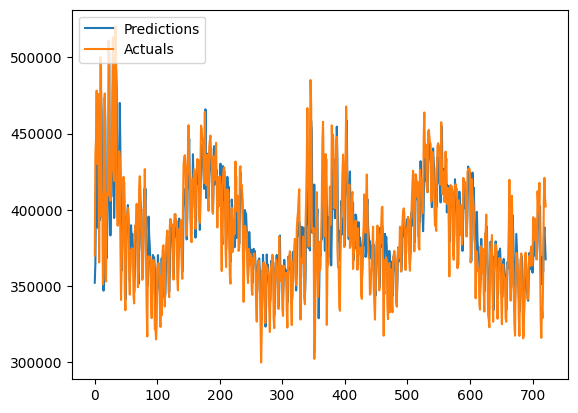

MAPE: 3.98%
RMSE: 20829.77
MAE : 15378.09


Predictions    Actuals
0    352231.31250  370080.05
1    365312.78125  435850.61
2    413233.71875  446686.34
3    407273.62500  478204.44
4    436407.90625  430133.90
..            ...        ...
718  382709.56250  405457.46
719  388622.75000  421027.63
720  378729.75000  407376.71
721  367591.56250  402263.51
722  372850.15625  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model1, X_val, y_val, 0, 722)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


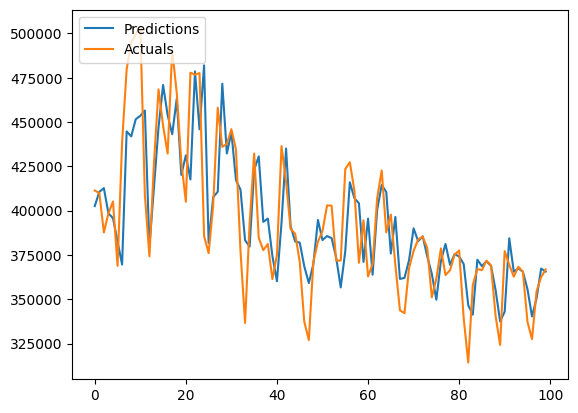

MAPE: 3.97%
RMSE: 20163.79
MAE : 15151.10


Predictions    Actuals
0    402568.12500  411339.27
1    410590.90625  409963.40
2    412706.18750  387672.63
3    398450.03125  398542.65
4    395749.87500  405159.36
..            ...        ...
353  366719.43750  360393.59
354  370774.28125  369325.03
355  359517.62500  371819.56
356  364718.09375  399427.25
357  379998.37500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model1, X_test, y_test, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 2 - Overlapping Windows ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

# Initialise variables for input layer
i = X_train2.shape[1]
j = X_train2.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model2 = create_lstm_model()

# create model checkpoint
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)

# compile model
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


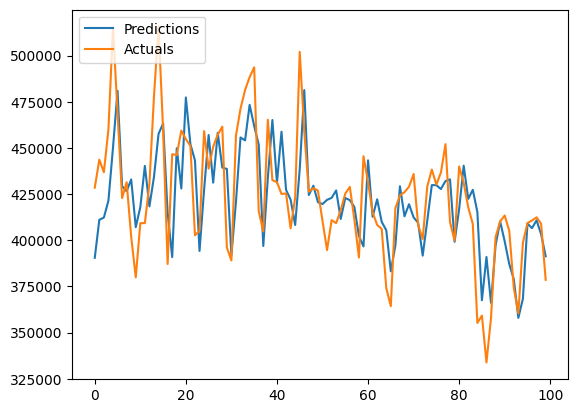

MAPE: 3.59%
RMSE: 18443.64
MAE : 14047.00


Predictions    Actuals
0     390516.75000  428486.93
1     411080.40625  443638.09
2     412333.87500  436849.95
3     421449.00000  460042.56
4     450141.65625  515344.46
...            ...        ...
2545  381248.34375  366570.55
2546  373211.81250  396529.66
2547  390612.71875  430688.95
2548  403311.71875  423274.20
2549  384042.40625  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model2 = load_model('model2.keras')

# print training metrics
predictions_plot(model2, X_train2, y_train2, 0, 100)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


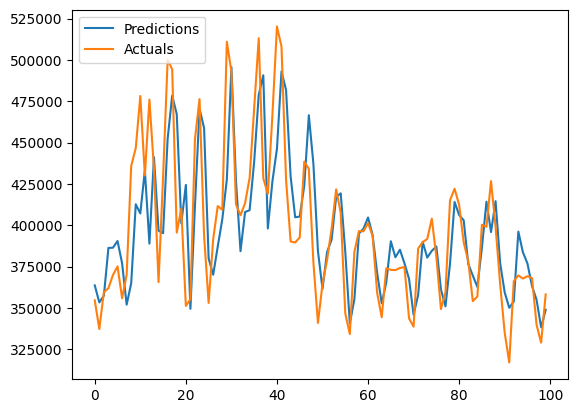

MAPE: 3.99%
RMSE: 20820.86
MAE : 15353.09


Predictions    Actuals
0    363645.90625  354595.19
1    353348.15625  337241.55
2    357426.12500  359586.54
3    386312.96875  361901.84
4    386429.93750  369989.09
..            ...        ...
732  383893.46875  405457.46
733  389615.09375  421027.63
734  376188.46875  407376.71
735  367832.34375  402263.51
736  371968.78125  405023.08

[737 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


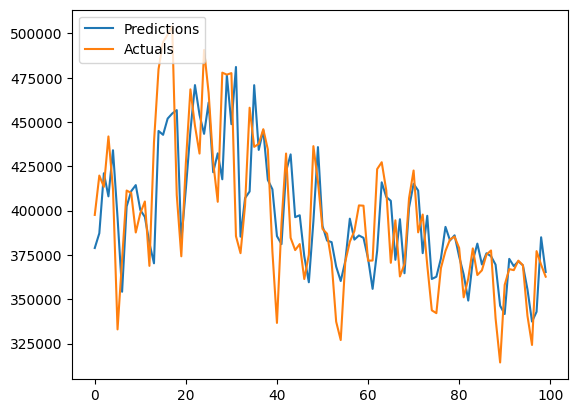

MAPE: 4.05%
RMSE: 20493.61
MAE : 15421.25


Predictions    Actuals
0    378921.78125  397576.81
1    387246.03125  419793.03
2    421075.03125  413402.43
3    408060.50000  441857.98
4    434073.18750  412076.90
..            ...        ...
360  367838.90625  360393.59
361  371429.59375  369325.03
362  360264.65625  371819.56
363  364834.87500  399427.25
364  380331.31250  408178.89

[365 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model2, X_test2, y_test2, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 2. Introducing Temperature... ##

In [ ]:
# Add average temperature to features
tempDemandDF = test_df[['sum_30_min_demand', 'avg_temp']]

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

# Initialise variables for input layer
i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [ ]:
# set seed
reset_seed()

# create model
model3 = create_lstm_model()

# create model checkpoint
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)

# compile model
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


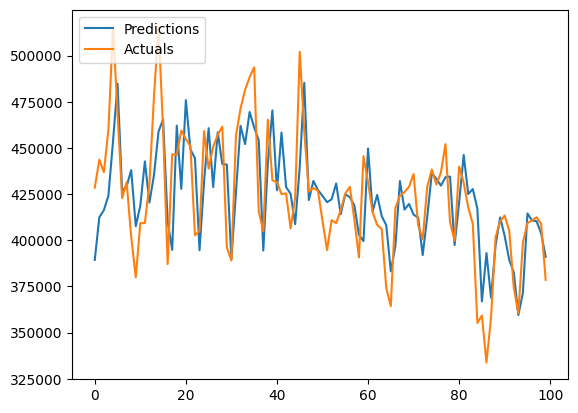

MAPE: 3.69%
RMSE: 18563.01
MAE : 14330.52


Predictions    Actuals
0     389395.34375  428486.93
1     412472.96875  443638.09
2     416314.09375  436849.95
3     424236.71875  460042.56
4     453393.28125  515344.46
...            ...        ...
2545  384875.87500  366570.55
2546  383098.43750  396529.66
2547  400374.25000  430688.95
2548  414362.40625  423274.20
2549  394721.71875  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model3 = load_model('model3.keras')

# print training metrics
predictions_plot(model3, X_train3, y_train3, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


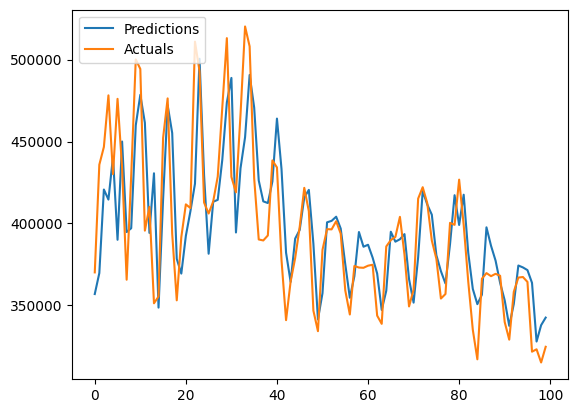

MAPE: 4.06%
RMSE: 20766.25
MAE : 15547.90


Predictions    Actuals
0    356857.50000  370080.05
1    369654.46875  435850.61
2    420699.75000  446686.34
3    414551.53125  478204.44
4    440697.31250  430133.90
..            ...        ...
718  386605.40625  405457.46
719  401700.84375  421027.63
720  395779.31250  407376.71
721  378402.87500  402263.51
722  377689.53125  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


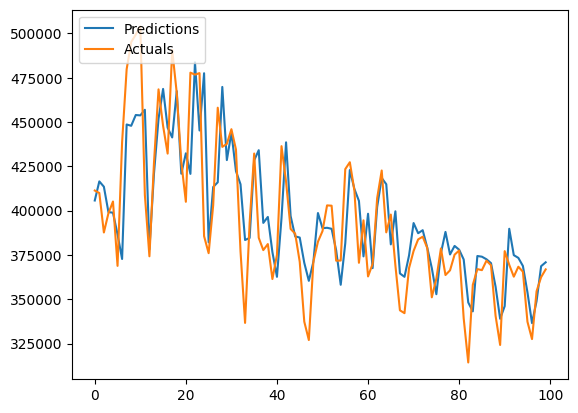

MAPE: 4.09%
RMSE: 20536.03
MAE : 15449.97


Predictions    Actuals
0    405714.50000  411339.27
1    416495.15625  409963.40
2    413496.43750  387672.63
3    399168.03125  398542.65
4    398844.81250  405159.36
..            ...        ...
353  370592.71875  360393.59
354  381255.03125  369325.03
355  375656.87500  371819.56
356  378422.53125  399427.25
357  391659.53125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model3, X_test3, y_test3, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 3. Testing Temp Measures ##

In [ ]:
# Add Min and Max Temp to features
tempDemandDF2 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

### Model 4 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

# Initialise variables for input layer
i = X_train4.shape[1]
j = X_train4.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model4 = create_lstm_model()

# create model checkpoint
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)

# compile model
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


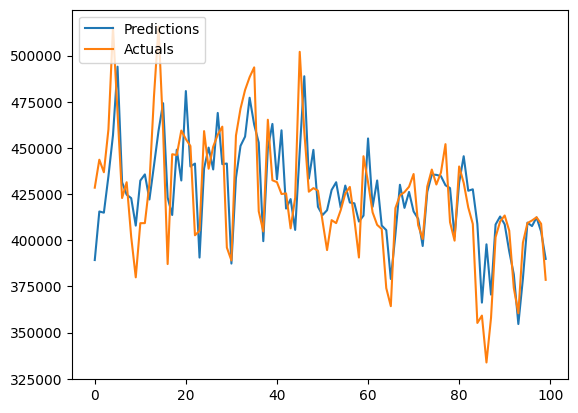

MAPE: 3.38%
RMSE: 17318.89
MAE : 13085.28


Predictions    Actuals
0     389308.93750  428486.93
1     415602.50000  443638.09
2     414961.87500  436849.95
3     434690.84375  460042.56
4     456979.21875  515344.46
...            ...        ...
2545  388237.46875  366570.55
2546  383784.68750  396529.66
2547  408223.75000  430688.95
2548  426840.18750  423274.20
2549  412660.78125  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model4 = load_model('model4.keras')

# print training metrics
predictions_plot(model4, X_train4, y_train4, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


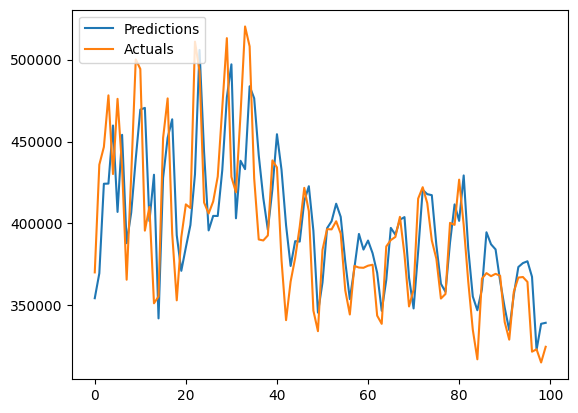

MAPE: 3.93%
RMSE: 20363.57
MAE : 15060.23


Predictions    Actuals
0    354312.62500  370080.05
1    369524.12500  435850.61
2    424215.84375  446686.34
3    424312.50000  478204.44
4    459782.84375  430133.90
..            ...        ...
718  389994.81250  405457.46
719  409111.53125  421027.63
720  412730.56250  407376.71
721  392510.87500  402263.51
722  384750.96875  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


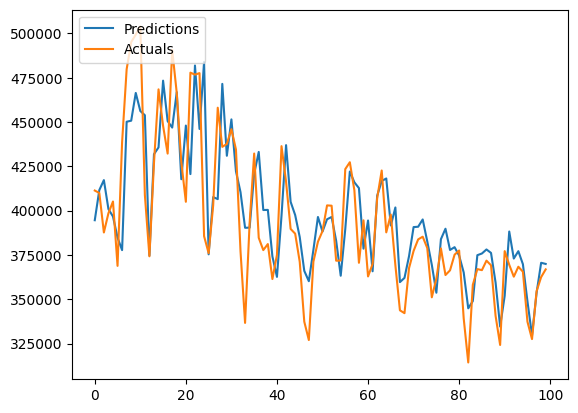

MAPE: 3.93%
RMSE: 19803.97
MAE : 14864.80


Predictions    Actuals
0    394590.00000  411339.27
1    411614.34375  409963.40
2    417218.43750  387672.63
3    400893.78125  398542.65
4    396690.09375  405159.36
..            ...        ...
353  373281.43750  360393.59
354  378482.53125  369325.03
355  377155.68750  371819.56
356  383408.53125  399427.25
357  400757.56250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model4, X_test4, y_test4, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 5 ###

In [ ]:
# create temp_range feature
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

# Add temperature range to features and drop min and max temperature
tempDemandDF3 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

# Initialise variables for input layer
i = X_train5.shape[1]
j = X_train5.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model5 = create_lstm_model()

# create model checkpoint
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)

# compile model
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


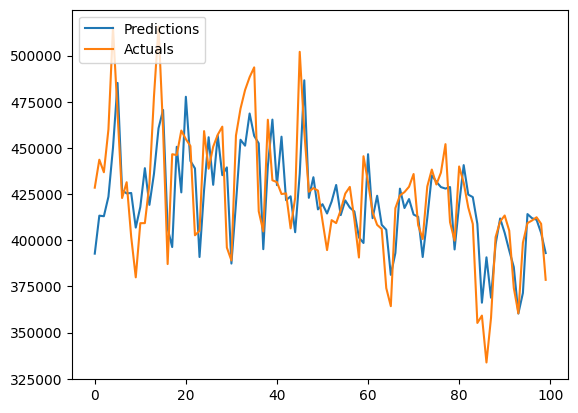

MAPE: 3.66%
RMSE: 18447.95
MAE : 14228.52


Predictions    Actuals
0     392771.90625  428486.93
1     413339.00000  443638.09
2     413039.21875  436849.95
3     423596.15625  460042.56
4     450068.25000  515344.46
...            ...        ...
2545  381536.28125  366570.55
2546  382742.34375  396529.66
2547  404647.03125  430688.95
2548  417489.78125  423274.20
2549  395204.78125  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model5 = load_model('model5.keras')

# print training metrics
predictions_plot(model5, X_train5, y_train5, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


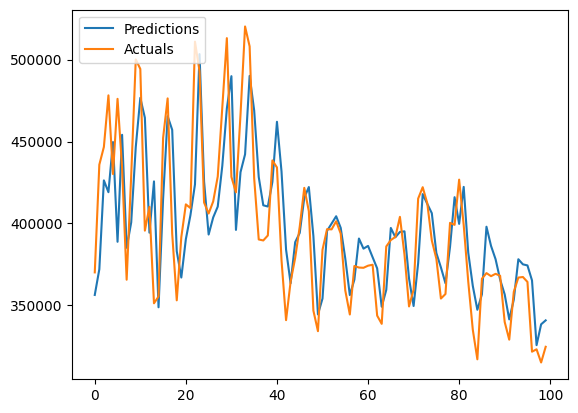

MAPE: 4.11%
RMSE: 20843.43
MAE : 15709.31


Predictions    Actuals
0    356307.03125  370080.05
1    371986.12500  435850.61
2    426275.62500  446686.34
3    419064.25000  478204.44
4    449682.40625  430133.90
..            ...        ...
718  387546.90625  405457.46
719  406365.50000  421027.63
720  399438.75000  407376.71
721  379961.06250  402263.51
722  377624.18750  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


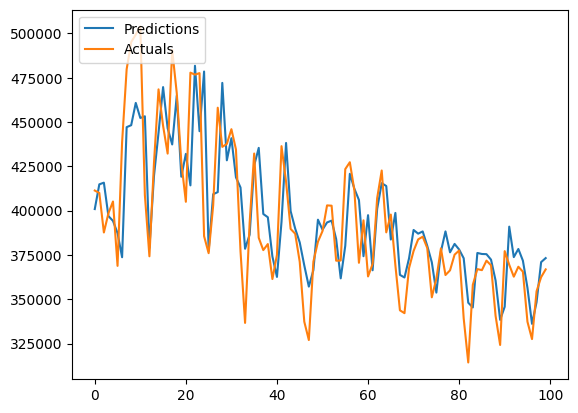

MAPE: 4.15%
RMSE: 20639.99
MAE : 15685.82


Predictions    Actuals
0    400881.21875  411339.27
1    414836.34375  409963.40
2    415775.18750  387672.63
3    396935.50000  398542.65
4    394216.75000  405159.36
..            ...        ...
353  369043.25000  360393.59
354  377222.12500  369325.03
355  374111.34375  371819.56
356  377058.65625  399427.25
357  393713.78125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model5, X_test5, y_test5, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 6 ###

In [ ]:
# Add min and max temperature back into features
tempDemandDF4 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

# Initialise variables for input layer
i = X_train6.shape[1]
j = X_train6.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model6 = create_lstm_model()

# create model checkpoint
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)

# compile model
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es1])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0405 - root_mean_squared_error: 0.1948 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss:

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


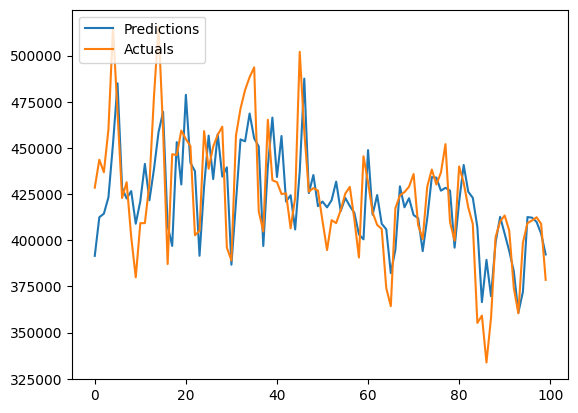

MAPE: 3.67%
RMSE: 18426.94
MAE : 14252.12


Predictions    Actuals
0     391580.90625  428486.93
1     412480.68750  443638.09
2     414411.87500  436849.95
3     423262.87500  460042.56
4     452167.25000  515344.46
...            ...        ...
2545  383161.93750  366570.55
2546  382357.34375  396529.66
2547  404402.40625  430688.95
2548  413812.18750  423274.20
2549  393637.25000  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model6 = load_model('model6.keras')

# print training metrics
predictions_plot(model6, X_train6, y_train6, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


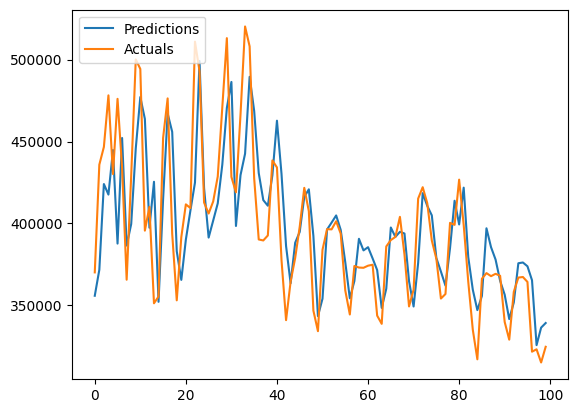

MAPE: 4.10%
RMSE: 20802.46
MAE : 15671.29


Predictions    Actuals
0    355808.68750  370080.05
1    371666.75000  435850.61
2    424041.81250  446686.34
3    417597.21875  478204.44
4    444792.62500  430133.90
..            ...        ...
718  386945.40625  405457.46
719  403924.40625  421027.63
720  398951.15625  407376.71
721  379985.68750  402263.51
722  376960.93750  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


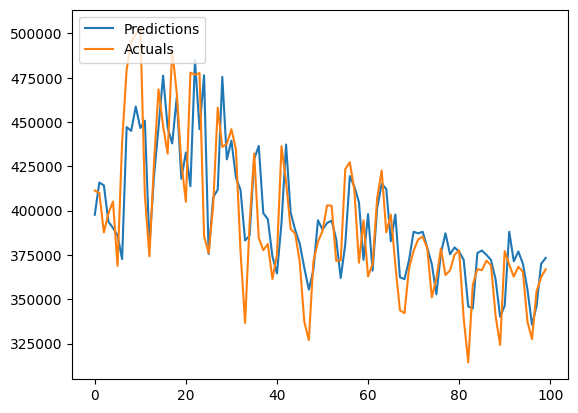

MAPE: 4.16%
RMSE: 20756.61
MAE : 15713.78


Predictions    Actuals
0    397648.31250  411339.27
1    415865.21875  409963.40
2    414248.90625  387672.63
3    393761.96875  398542.65
4    390231.93750  405159.36
..            ...        ...
353  368490.96875  360393.59
354  375096.21875  369325.03
355  374323.40625  371819.56
356  375460.09375  399427.25
357  391642.62500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model6, X_test6, y_test6, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 7 - Increase Window Size to 10 ##

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

# Initialise variables for input layer
i = X_train7.shape[1]
j = X_train7.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model7 = create_lstm_model()

# create model checkpoint
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)

# compile model
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


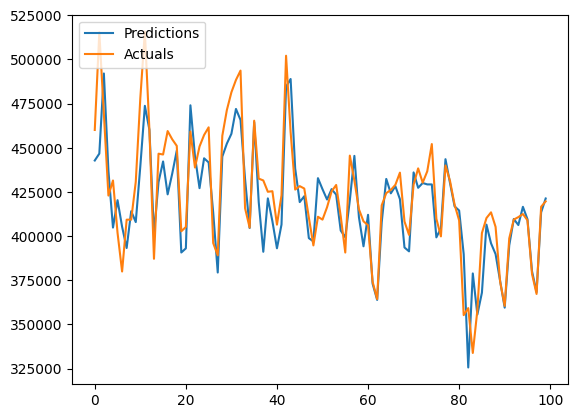

MAPE: 2.55%
RMSE: 13720.03
MAE : 9988.77


Predictions    Actuals
0     442753.37500  460042.56
1     446662.81250  515344.46
2     492013.12500  469035.36
3     436835.31250  422902.33
4     404805.31250  431459.14
...            ...        ...
2542  363454.50000  366570.55
2543  372346.43750  396529.66
2544  392908.96875  430688.95
2545  406323.90625  423274.20
2546  381781.12500  393378.87

[2547 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model7 = load_model('model7.keras')

# print training metrics
predictions_plot(model7, X_train7, y_train7, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


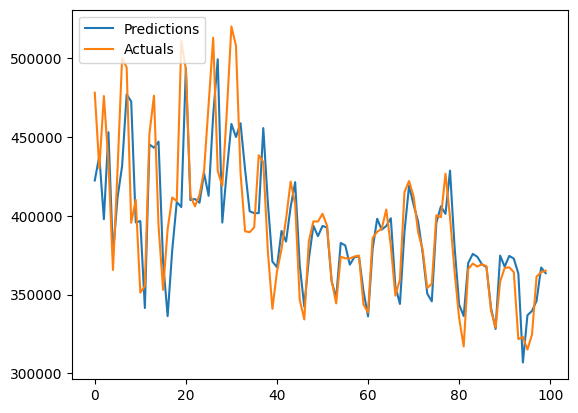

MAPE: 3.27%
RMSE: 18468.45
MAE : 12701.12


Predictions    Actuals
0    422433.87500  478204.44
1    438018.34375  430133.90
2    397866.34375  476078.57
3    453107.90625  433885.61
4    375742.84375  365607.37
..            ...        ...
715  367972.53125  405457.46
716  399183.12500  421027.63
717  387163.37500  407376.71
718  366409.12500  402263.51
719  365631.68750  405023.08

[720 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


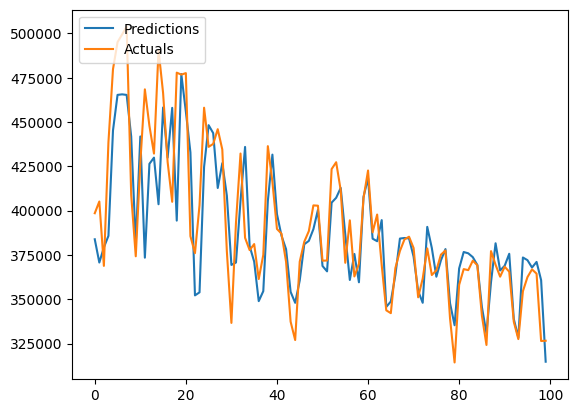

MAPE: 3.41%
RMSE: 18464.03
MAE : 13063.41


Predictions    Actuals
0    383847.03125  398542.65
1    370726.68750  405159.36
2    379254.81250  368840.45
3    385770.31250  438517.06
4    445190.00000  479784.41
..            ...        ...
350  347881.65625  360393.59
351  356400.56250  369325.03
352  362751.46875  371819.56
353  373871.90625  399427.25
354  390207.06250  408178.89

[355 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model7, X_test7, y_test7, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history7.history['loss'], label='Train Loss')
plt.plot(history7.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 8 - Decrease Window Size to 5 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

# Initialise variables for input layer
i = X_train8.shape[1]
j = X_train8.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model8 = create_lstm_model()

# create model checkpoint
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)

# compile model
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es3])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


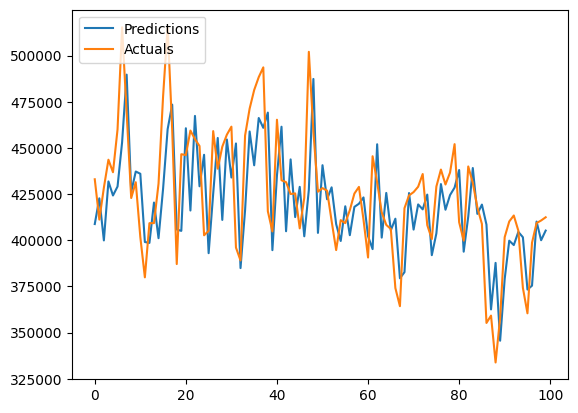

MAPE: 4.19%
RMSE: 21025.27
MAE : 16270.09


Predictions    Actuals
0     408799.59375  433042.65
1     422721.65625  411208.68
2     399933.71875  428486.93
3     431883.84375  443638.09
4     424261.12500  436849.95
...            ...        ...
2547  373561.34375  366570.55
2548  365671.09375  396529.66
2549  396153.81250  430688.95
2550  410103.96875  423274.20
2551  398210.71875  393378.87

[2552 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model8 = load_model('model8.keras')

# print training metrics
predictions_plot(model8, X_train8, y_train8, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


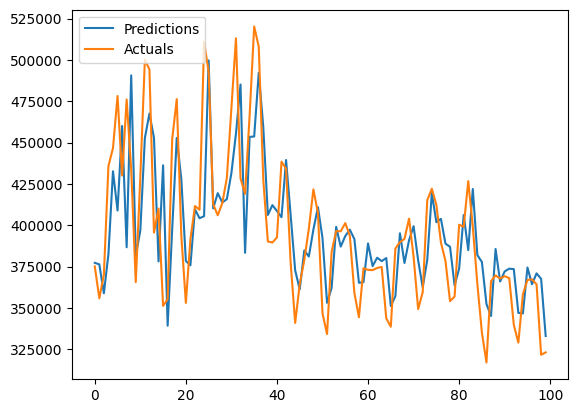

MAPE: 4.44%
RMSE: 22111.44
MAE : 16949.16


Predictions    Actuals
0    377285.81250  375151.30
1    376342.68750  355851.85
2    358889.21875  370080.05
3    382521.90625  435850.61
4    432681.81250  446686.34
..            ...        ...
720  369488.53125  405457.46
721  394887.75000  421027.63
722  394415.46875  407376.71
723  389609.21875  402263.51
724  393051.68750  405023.08

[725 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


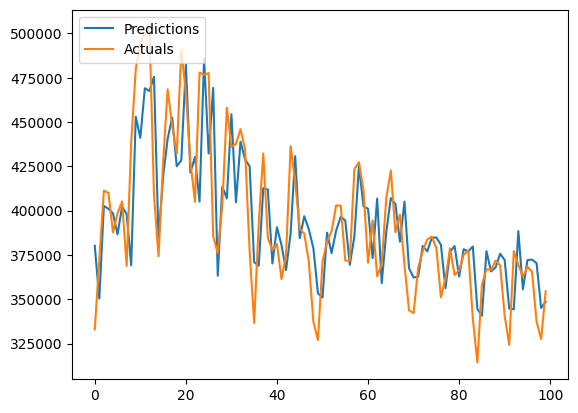

MAPE: 4.43%
RMSE: 21877.25
MAE : 16635.40


Predictions    Actuals
0    380138.03125  333009.61
1    350365.56250  372457.04
2    402655.62500  411339.27
3    401052.46875  409963.40
4    398433.90625  387672.63
..            ...        ...
355  359252.40625  360393.59
356  364188.46875  369325.03
357  367952.68750  371819.56
358  372067.81250  399427.25
359  396798.53125  408178.89

[360 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model8, X_test8, y_test8, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 9 - Increase Window Size to 14 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

# Initialise variables for input layer
i = X_train9.shape[1]
j = X_train9.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model9 = create_lstm_model()

# create model checkpoint
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)

# compile model
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


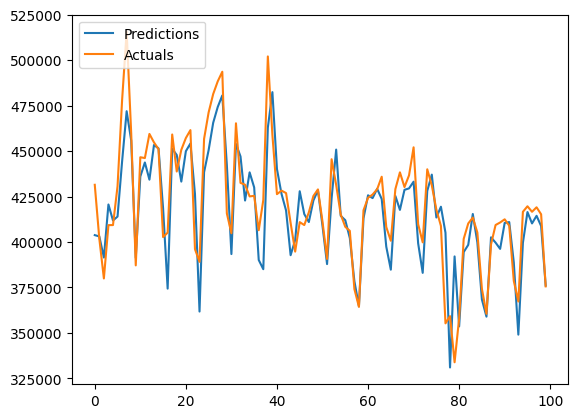

MAPE: 2.63%
RMSE: 14184.65
MAE : 10291.90


Predictions    Actuals
0     403766.96875  431459.14
1     403055.78125  401807.19
2     391450.78125  379940.96
3     420636.18750  409269.07
4     411827.62500  409301.24
...            ...        ...
2538  376618.71875  366570.55
2539  362222.03125  396529.66
2540  394098.12500  430688.95
2541  405432.00000  423274.20
2542  386575.40625  393378.87

[2543 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model9 = load_model('model9.keras')

# print training metrics
predictions_plot(model9, X_train9, y_train9, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


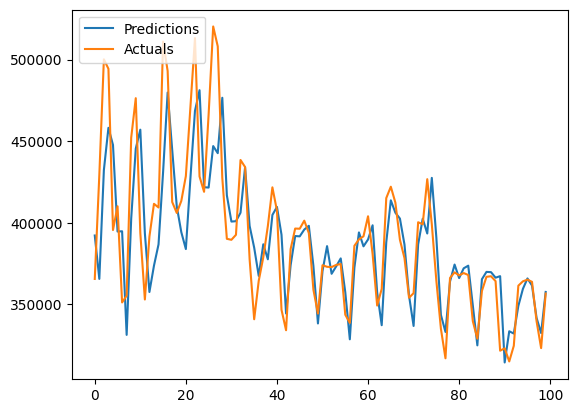

MAPE: 3.30%
RMSE: 18240.38
MAE : 12807.09


Predictions    Actuals
0    392233.78125  365607.37
1    365631.25000  429271.68
2    432314.34375  500151.18
3    458209.62500  494331.59
4    447688.00000  395585.67
..            ...        ...
711  364412.34375  405457.46
712  397428.59375  421027.63
713  388297.56250  407376.71
714  357867.78125  402263.51
715  376010.28125  405023.08

[716 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


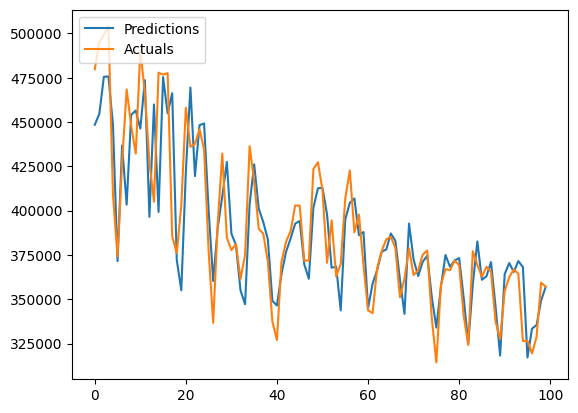

MAPE: 3.25%
RMSE: 17265.33
MAE : 12401.45


Predictions    Actuals
0    448430.34375  479784.41
1    454566.56250  495056.95
2    475499.81250  499342.29
3    475717.50000  503885.71
4    448178.53125  408832.77
..            ...        ...
346  346772.06250  360393.59
347  354205.28125  369325.03
348  355760.21875  371819.56
349  370639.71875  399427.25
350  388052.59375  408178.89

[351 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model9, X_test9, y_test9, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history9.history['loss'], label='Train Loss')
plt.plot(history9.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 10 - Add CDD/HDD ###

In [ ]:
# Add cooling degree days and heating degree days into feature set
tempDemandDF5 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

# Initialise variables for input layer
i = X_train10.shape[1]
j = X_train10.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model10 = create_lstm_model()

# create model checkpoint
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)

# compile model
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


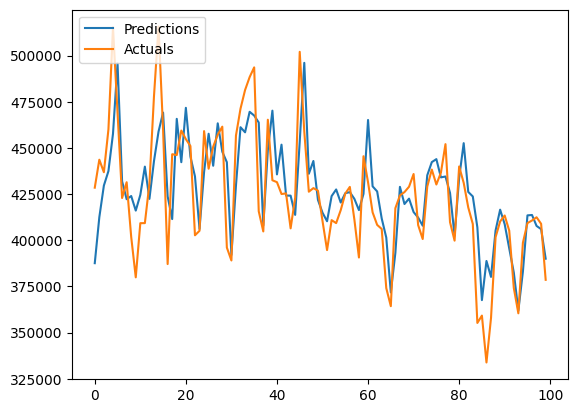

MAPE: 3.51%
RMSE: 17683.78
MAE : 13506.46


Predictions    Actuals
0     387606.78125  428486.93
1     412490.75000  443638.09
2     429635.71875  436849.95
3     437461.25000  460042.56
4     457665.06250  515344.46
...            ...        ...
2545  394790.03125  366570.55
2546  392433.56250  396529.66
2547  411712.71875  430688.95
2548  423736.21875  423274.20
2549  410981.21875  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model10 = load_model('model10.keras')

# print training metrics
predictions_plot(model10, X_train10, y_train10, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


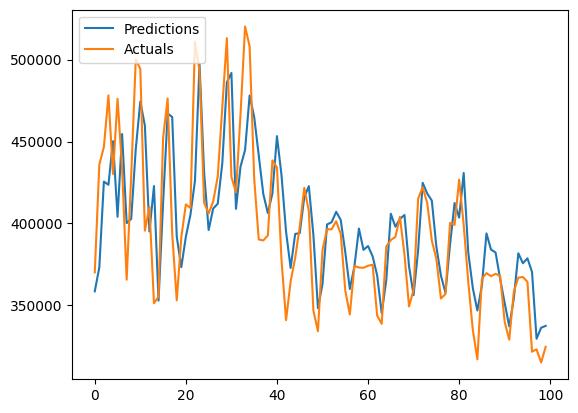

MAPE: 3.94%
RMSE: 20224.86
MAE : 15029.86


Predictions    Actuals
0    358509.03125  370080.05
1    373177.43750  435850.61
2    425530.46875  446686.34
3    423591.90625  478204.44
4    450199.81250  430133.90
..            ...        ...
718  392779.43750  405457.46
719  407959.59375  421027.63
720  404193.43750  407376.71
721  388568.84375  402263.51
722  386257.31250  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


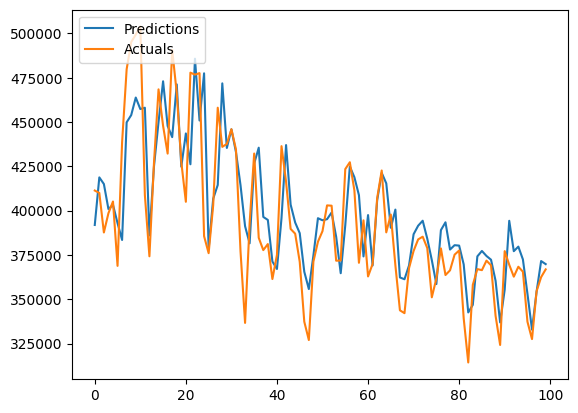

MAPE: 4.05%
RMSE: 20071.93
MAE : 15199.75


Predictions    Actuals
0    391909.87500  411339.27
1    418758.12500  409963.40
2    415019.93750  387672.63
3    400898.40625  398542.65
4    403286.09375  405159.36
..            ...        ...
353  378471.28125  360393.59
354  386420.21875  369325.03
355  384551.06250  371819.56
356  389905.12500  399427.25
357  401259.59375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model10, X_test10, y_test10, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history10.history['loss'], label='Train Loss')
plt.plot(history10.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 11 - Remove Avg Temp from Model 10 ###

In [ ]:
# Remove average temperature
tempDemandDF6 = test_df[['sum_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

# Initialise variables for input layer
i = X_train11.shape[1]
j = X_train11.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model11 = create_lstm_model()

# create model checkpoint
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)

# compile model
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


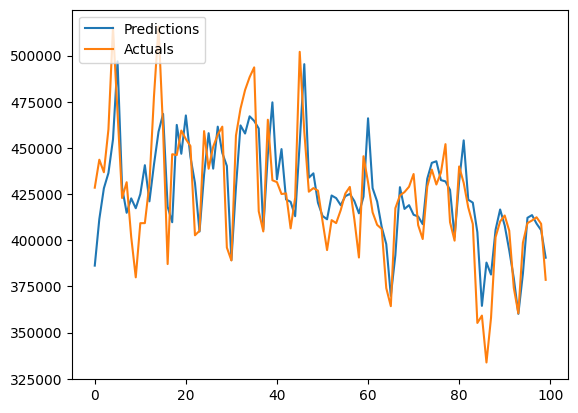

MAPE: 3.44%
RMSE: 17421.61
MAE : 13287.33


Predictions    Actuals
0     386287.43750  428486.93
1     411488.84375  443638.09
2     428153.62500  436849.95
3     436432.34375  460042.56
4     454626.56250  515344.46
...            ...        ...
2545  392641.50000  366570.55
2546  392105.62500  396529.66
2547  409685.09375  430688.95
2548  416737.50000  423274.20
2549  408721.65625  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model11 = load_model('model11.keras')

# print training metrics
predictions_plot(model11, X_train11, y_train11, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


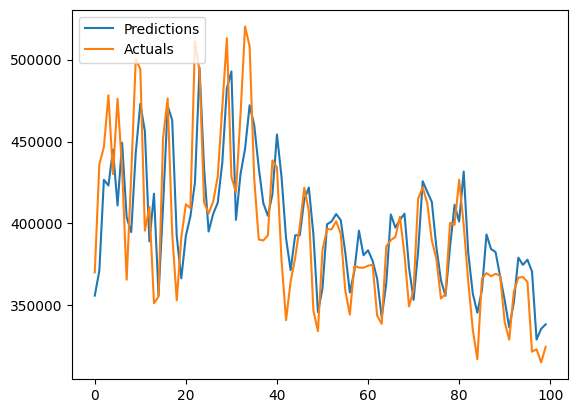

MAPE: 3.85%
RMSE: 19887.26
MAE : 14736.83


Predictions    Actuals
0    355874.34375  370080.05
1    371008.62500  435850.61
2    426633.18750  446686.34
3    423160.21875  478204.44
4    445054.25000  430133.90
..            ...        ...
718  389688.12500  405457.46
719  407787.21875  421027.63
720  401357.93750  407376.71
721  387603.06250  402263.51
722  384383.84375  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


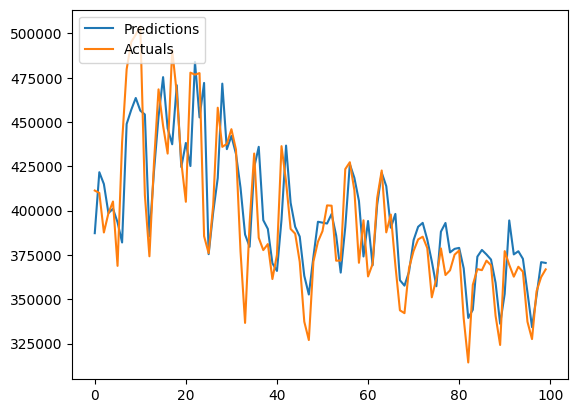

MAPE: 3.96%
RMSE: 19621.08
MAE : 14939.47


Predictions    Actuals
0    387284.46875  411339.27
1    421684.62500  409963.40
2    415013.96875  387672.63
3    398586.28125  398542.65
4    401075.65625  405159.36
..            ...        ...
353  374632.06250  360393.59
354  384018.81250  369325.03
355  381977.28125  371819.56
356  387662.53125  399427.25
357  397448.21875  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model11, X_test11, y_test11, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history11.history['loss'], label='Train Loss')
plt.plot(history11.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 4. Seasonality ##

### Seasons ###

In [ ]:
# Add season measures to the dataset
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

# Initialise variables for input layer
i = X_train12.shape[1]
j = X_train12.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model12 = create_lstm_model()

# create model checkpoint
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)

# compile model
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es2])

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


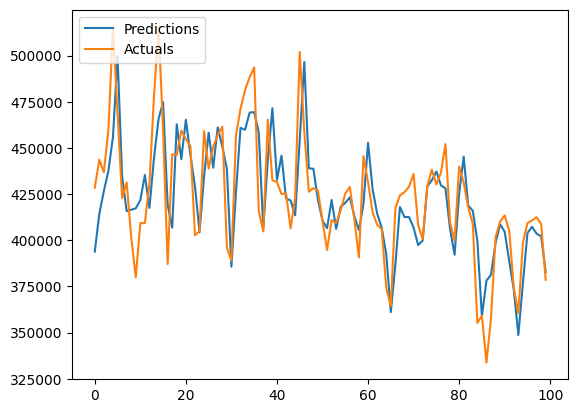

MAPE: 3.20%
RMSE: 16505.35
MAE : 12414.69


Predictions    Actuals
0     393866.56250  428486.93
1     414324.28125  443638.09
2     426750.03125  436849.95
3     437657.87500  460042.56
4     456126.84375  515344.46
...            ...        ...
2545  388361.15625  366570.55
2546  386308.03125  396529.66
2547  407122.68750  430688.95
2548  413969.75000  423274.20
2549  405439.37500  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model12 = load_model('model12.keras')

# print training metrics
predictions_plot(model12, X_train12, y_train12, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


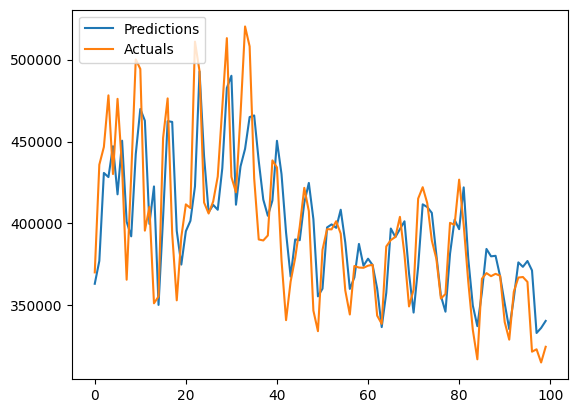

MAPE: 3.69%
RMSE: 19359.38
MAE : 14117.23


Predictions    Actuals
0    363131.87500  370080.05
1    377083.15625  435850.61
2    430815.03125  446686.34
3    428296.87500  478204.44
4    447124.65625  430133.90
..            ...        ...
718  387493.12500  405457.46
719  409902.53125  421027.63
720  405492.68750  407376.71
721  391330.28125  402263.51
722  388197.75000  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


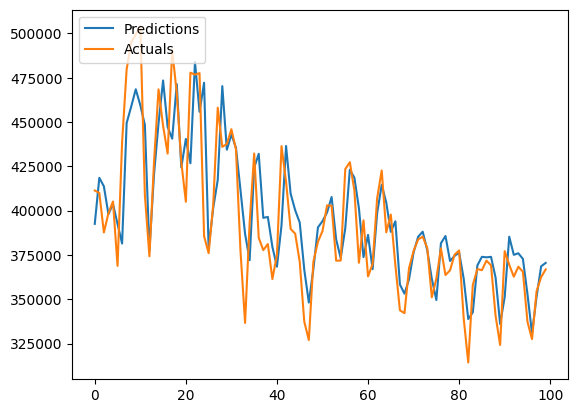

MAPE: 3.70%
RMSE: 18680.95
MAE : 13927.45


Predictions    Actuals
0    392538.37500  411339.27
1    418516.46875  409963.40
2    413714.96875  387672.63
3    398017.21875  398542.65
4    403776.68750  405159.36
..            ...        ...
353  371319.21875  360393.59
354  380330.93750  369325.03
355  380279.03125  371819.56
356  384514.03125  399427.25
357  396519.03125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model12, X_test12, y_test12, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history12.history['loss'], label='Train Loss')
plt.plot(history12.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Weekday/Weekend ###

In [ ]:
# Remove seasons and investigate the introduction of weekday/weekend dichotomy
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

# Initialise variables for input layer
i = X_train13.shape[1]
j = X_train13.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model13 = create_lstm_model()

# create model checkpoint
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)

# compile model
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


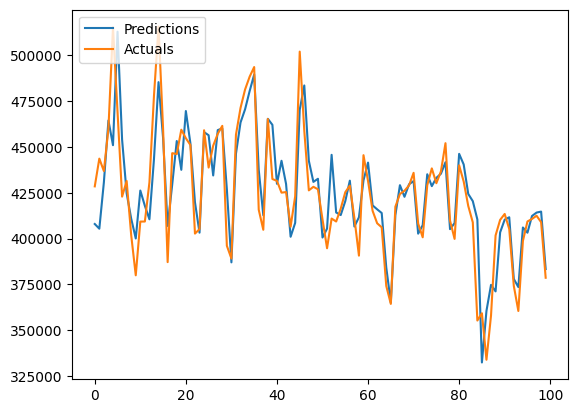

MAPE: 2.42%
RMSE: 13293.56
MAE : 9394.32


Predictions    Actuals
0     407950.28125  428486.93
1     405382.56250  443638.09
2     430688.37500  436849.95
3     464469.56250  460042.56
4     450975.00000  515344.46
...            ...        ...
2545  361360.59375  366570.55
2546  371919.34375  396529.66
2547  402514.59375  430688.95
2548  407163.59375  423274.20
2549  379078.12500  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model13 = load_model('model16.keras')

# print training metrics
predictions_plot(model13, X_train13, y_train13, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


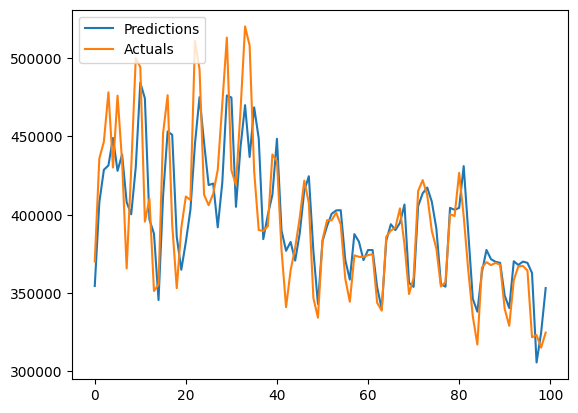

MAPE: 2.90%
RMSE: 16452.51
MAE : 11230.29


Predictions    Actuals
0    354425.03125  370080.05
1    407865.28125  435850.61
2    428680.31250  446686.34
3    431498.34375  478204.44
4    449007.25000  430133.90
..            ...        ...
718  367571.78125  405457.46
719  402356.90625  421027.63
720  373713.93750  407376.71
721  386576.31250  402263.51
722  406494.93750  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


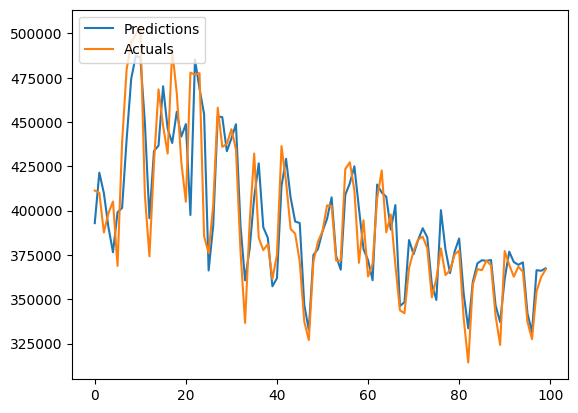

MAPE: 3.01%
RMSE: 15892.54
MAE : 11453.72


Predictions    Actuals
0    392945.75000  411339.27
1    421418.56250  409963.40
2    409861.46875  387672.63
3    390699.84375  398542.65
4    376527.15625  405159.36
..            ...        ...
353  351805.31250  360393.59
354  344555.87500  369325.03
355  368557.53125  371819.56
356  398443.34375  399427.25
357  383947.87500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model13, X_test13, y_test13, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history13.history['loss'], label='Train Loss')
plt.plot(history13.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Day Of Week ###

In [ ]:
# Investigate Day Of Week features
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

# Initialise variables for input layer
i = X_train14.shape[1]
j = X_train14.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model14 = create_lstm_model()

# create model checkpoint
cp14 = ModelCheckpoint('model17.keras', save_best_only=True)

# compile model
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


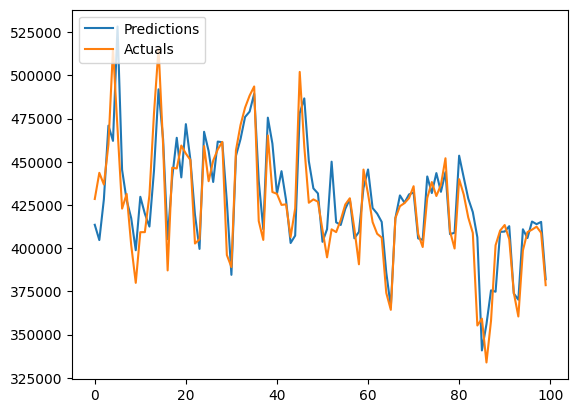

MAPE: 2.45%
RMSE: 13337.62
MAE : 9541.87


Predictions    Actuals
0     413555.59375  428486.93
1     404697.65625  443638.09
2     428302.09375  436849.95
3     470976.46875  460042.56
4     462140.96875  515344.46
...            ...        ...
2545  363943.68750  366570.55
2546  378229.37500  396529.66
2547  403971.84375  430688.95
2548  405797.40625  423274.20
2549  365903.93750  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model14 = load_model('model14.keras')

# print training metrics
predictions_plot(model14, X_train14, y_train14, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


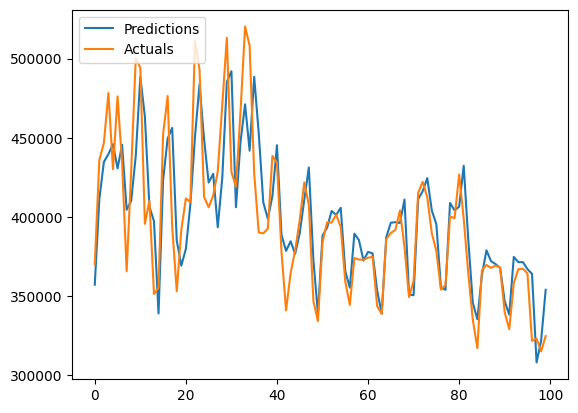

MAPE: 3.01%
RMSE: 16699.69
MAE : 11598.49


Predictions    Actuals
0    357136.8125  370080.05
1    411176.3750  435850.61
2    434669.9375  446686.34
3    439631.8125  478204.44
4    445945.1875  430133.90
..           ...        ...
718  369253.4375  405457.46
719  410697.0000  421027.63
720  364746.6250  407376.71
721  393019.0625  402263.51
722  415763.1875  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


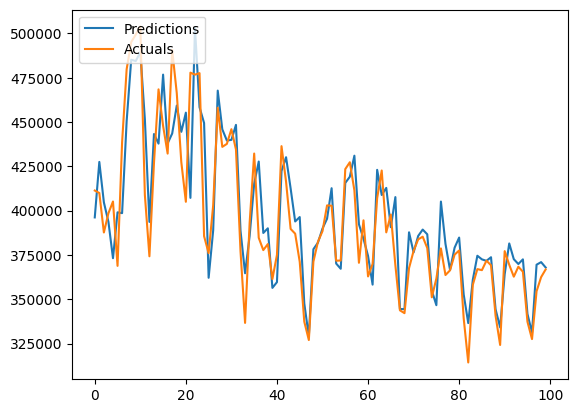

MAPE: 3.12%
RMSE: 16087.97
MAE : 11862.09


Predictions    Actuals
0    396170.90625  411339.27
1    427484.75000  409963.40
2    404673.50000  387672.63
3    393673.50000  398542.65
4    373167.25000  405159.36
..            ...        ...
353  350514.03125  360393.59
354  336791.00000  369325.03
355  370381.93750  371819.56
356  400405.62500  399427.25
357  391418.28125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model14, X_test14, y_test14, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history17.history['loss'], label='Train Loss')
plt.plot(history17.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Month ###

In [ ]:
# Investigate month features
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

# Initialise variables for input layer
i = X_train15.shape[1]
j = X_train15.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model15 = create_lstm_model()

# create model checkpoint
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)

# compile model
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


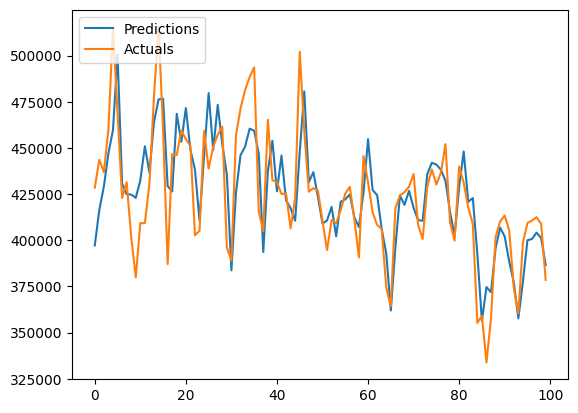

MAPE: 3.10%
RMSE: 15969.82
MAE : 12019.51


Predictions    Actuals
0     397240.93750  428486.93
1     416501.71875  443638.09
2     429122.40625  436849.95
3     447117.21875  460042.56
4     459715.75000  515344.46
...            ...        ...
2545  376947.59375  366570.55
2546  374017.25000  396529.66
2547  395990.18750  430688.95
2548  407430.96875  423274.20
2549  401786.25000  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model15 = load_model('model15.keras')

# print training metrics
predictions_plot(model15, X_train15, y_train15, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


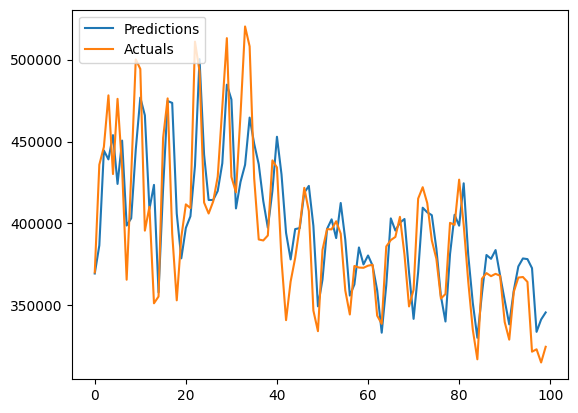

MAPE: 3.65%
RMSE: 19261.14
MAE : 14001.65


Predictions    Actuals
0    369401.18750  370080.05
1    386598.71875  435850.61
2    444520.75000  446686.34
3    439111.21875  478204.44
4    453916.59375  430133.90
..            ...        ...
718  377465.28125  405457.46
719  401827.68750  421027.63
720  403368.53125  407376.71
721  385853.59375  402263.51
722  381972.93750  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


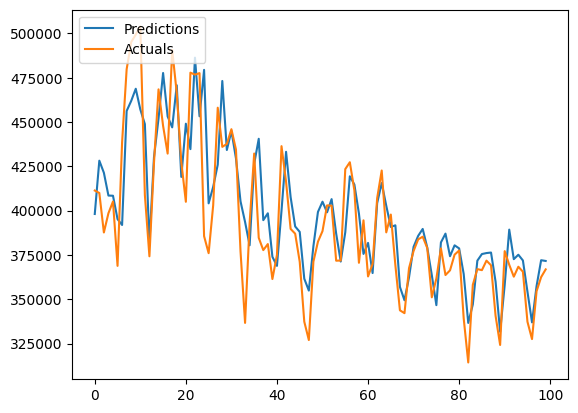

MAPE: 3.87%
RMSE: 19238.46
MAE : 14518.44


Predictions    Actuals
0    398108.46875  411339.27
1    428189.50000  409963.40
2    421370.68750  387672.63
3    408511.34375  398542.65
4    408406.50000  405159.36
..            ...        ...
353  359071.09375  360393.59
354  369076.46875  369325.03
355  370508.71875  371819.56
356  377027.93750  399427.25
357  388891.03125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model15, X_test15, y_test15, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history18.history['loss'], label='Train Loss')
plt.plot(history18.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Seasons & Weekday/Weekend ###

In [ ]:
# Add seasons and weekday/weekend to feature set from Model 10 (optimal so far)
# N.B. Seasons and weekday/weekend were chosen due to best results so far without
# overfitting.  Month features and day of week showed signs of overfitting
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

# Initialise variables for input layer
i = X_train16.shape[1]
j = X_train16.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model16 = create_lstm_model()

# create model checkpoint
cp16 = ModelCheckpoint('model19.keras', save_best_only=True)

# compile model
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


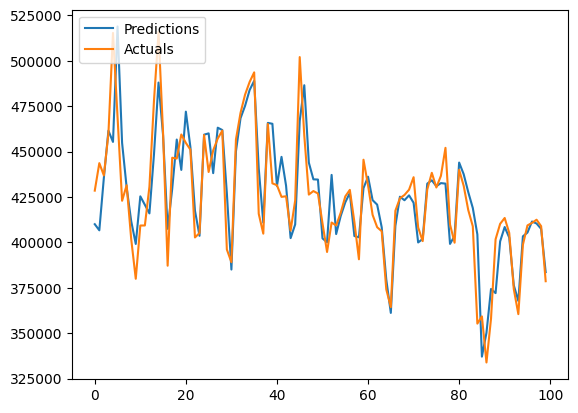

MAPE: 2.35%
RMSE: 12943.57
MAE : 9157.46


Predictions    Actuals
0     410007.50000  428486.93
1     406632.43750  443638.09
2     435667.65625  436849.95
3     461510.90625  460042.56
4     455323.68750  515344.46
...            ...        ...
2545  363990.96875  366570.55
2546  379636.53125  396529.66
2547  404310.90625  430688.95
2548  406721.40625  423274.20
2549  383887.87500  393378.87

[2550 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model16 = load_model('model16.keras')

# print training metrics
predictions_plot(model16, X_train16, y_train16, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


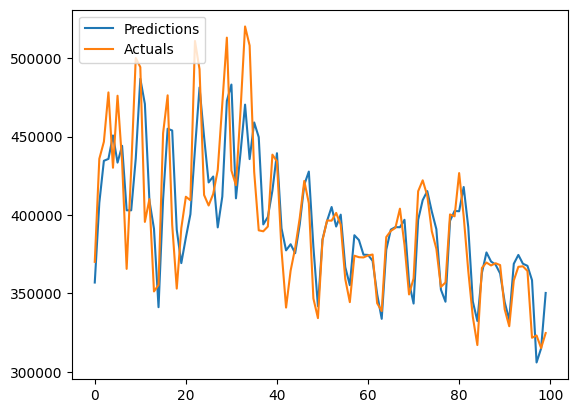

MAPE: 2.91%
RMSE: 16353.96
MAE : 11243.33


Predictions    Actuals
0    356892.00000  370080.05
1    407787.59375  435850.61
2    434559.18750  446686.34
3    435779.12500  478204.44
4    450753.62500  430133.90
..            ...        ...
718  375194.09375  405457.46
719  407304.00000  421027.63
720  381019.00000  407376.71
721  388614.59375  402263.51
722  411882.34375  405023.08

[723 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


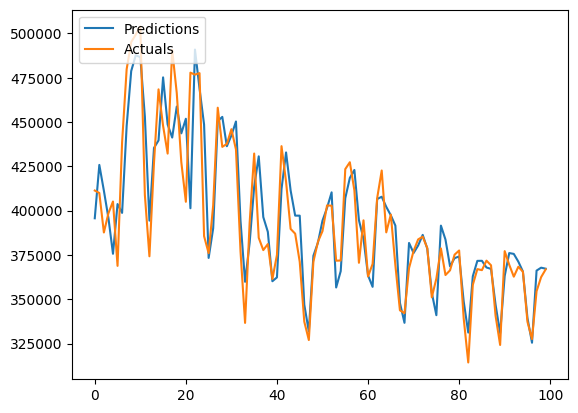

MAPE: 2.93%
RMSE: 15607.44
MAE : 11177.15


Predictions    Actuals
0    395683.71875  411339.27
1    425790.71875  409963.40
2    411273.09375  387672.63
3    395829.90625  398542.65
4    375661.65625  405159.36
..            ...        ...
353  354191.56250  360393.59
354  347599.28125  369325.03
355  368563.65625  371819.56
356  398779.93750  399427.25
357  389544.87500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model16, X_test16, y_test16, 0, 100)

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history19.history['loss'], label='Train Loss')
plt.plot(history19.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 5. Train/test only - Compare Most Successful Models ##

### Seasons & Weekday/Weekend - Train/Test ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train17, y_train17 = data17['train']
X_test17, y_test17 = data17['test']

# Initialise variables for input layer
i = X_train17.shape[1]
j = X_train17.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model17 = create_lstm_model()

# create model checkpoint
cp17 = ModelCheckpoint('model17.keras', monitor='loss', save_best_only=True)

# compile model
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history17 = model17.fit(X_train17, y_train17, epochs=100, callbacks=[cp17])

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


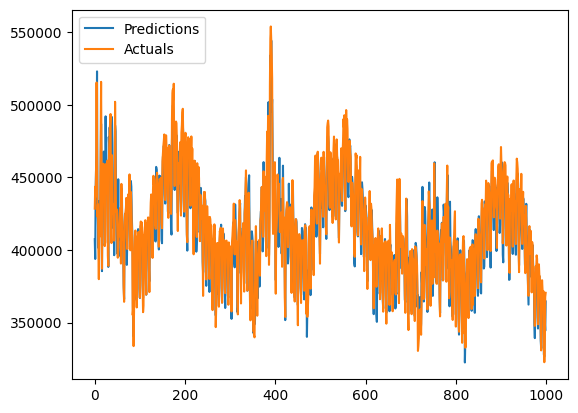

MAPE: 2.35%
RMSE: 12874.79
MAE : 9208.10


Predictions    Actuals
0     407452.25000  428486.93
1     393834.96875  443638.09
2     441359.34375  436849.95
3     457913.71875  460042.56
4     468264.31250  515344.46
...            ...        ...
3275  379319.53125  405457.46
3276  422662.68750  421027.63
3277  388575.56250  407376.71
3278  398040.28125  402263.51
3279  395173.96875  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model17 = load_model('model17.keras')

# print training metrics
predictions_plot(model17, X_train17, y_train17, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


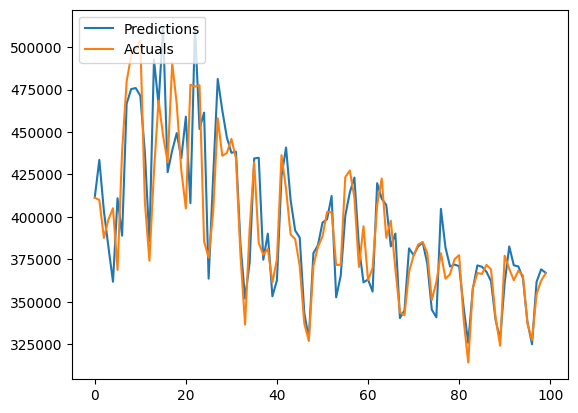

MAPE: 2.96%
RMSE: 16731.22
MAE : 11449.60


Predictions    Actuals
0    411449.75000  411339.27
1    433586.18750  409963.40
2    403613.18750  387672.63
3    382302.12500  398542.65
4    361875.03125  405159.36
..            ...        ...
353  354152.84375  360393.59
354  350372.00000  369325.03
355  384044.68750  371819.56
356  397583.46875  399427.25
357  406640.06250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model17, X_test17, y_test17, 0, 100)

### Seasons Only - Train/Test ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train18, y_train18 = data18['train']
X_test18, y_test18 = data18['test']

# Initialise variables for input layer
i = X_train18.shape[1]
j = X_train18.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model18 = create_lstm_model()

# create model checkpoint
cp18 = ModelCheckpoint('model18.keras', monitor='loss', save_best_only=True)

# compile model
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history18 = model18.fit(X_train18, y_train18, epochs=100, callbacks=[cp18])

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


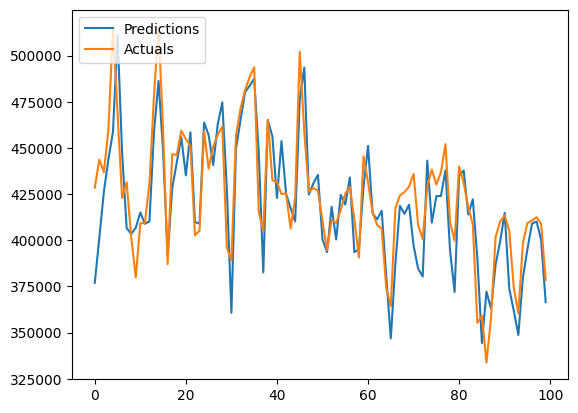

MAPE: 2.81%
RMSE: 15032.33
MAE : 10969.45


Predictions    Actuals
0     376987.25000  428486.93
1     401347.31250  443638.09
2     426243.18750  436849.95
3     443885.87500  460042.56
4     458819.75000  515344.46
...            ...        ...
3275  391474.31250  405457.46
3276  431243.43750  421027.63
3277  425538.37500  407376.71
3278  392993.84375  402263.51
3279  382249.12500  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model18 = load_model('model18.keras')

# print training metrics
predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


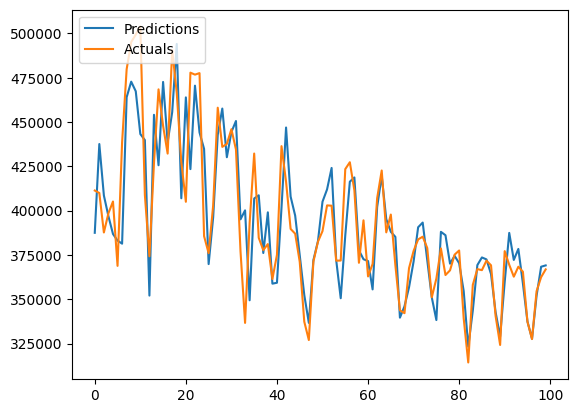

MAPE: 3.41%
RMSE: 17812.67
MAE : 13081.73


Predictions    Actuals
0    387497.31250  411339.27
1    437571.78125  409963.40
2    408563.71875  387672.63
3    396857.71875  398542.65
4    386822.50000  405159.36
..            ...        ...
353  379901.62500  360393.59
354  380084.18750  369325.03
355  390370.40625  371819.56
356  381128.87500  399427.25
357  414182.00000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model18, X_test18, y_test18, 0, 100)

### Weekend/Weekday Only - Train/Test ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train19, y_train19 = data19['train']
X_test19, y_test19 = data19['test']

# Initialise variables for input layer
i = X_train19.shape[1]
j = X_train19.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model19 = create_lstm_model()

# create model checkpoint
cp19 = ModelCheckpoint('model19.keras', monitor='loss', save_best_only=True)

# compile model
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history19 = model19.fit(X_train19, y_train19, epochs=100, callbacks=[cp19])

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


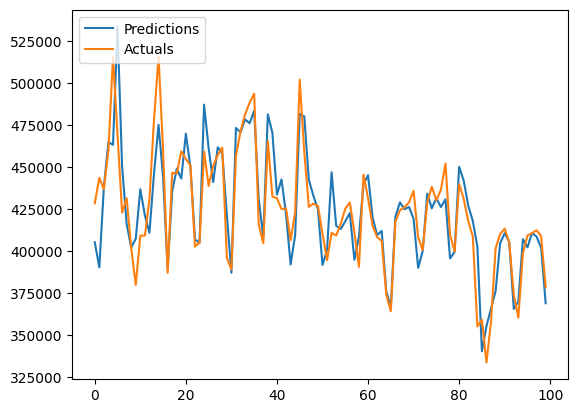

MAPE: 2.45%
RMSE: 13458.79
MAE : 9628.40


Predictions    Actuals
0     405315.34375  428486.93
1     390403.46875  443638.09
2     438105.59375  436849.95
3     464841.71875  460042.56
4     463206.21875  515344.46
...            ...        ...
3275  374796.59375  405457.46
3276  408312.78125  421027.63
3277  369685.06250  407376.71
3278  391029.06250  402263.51
3279  403769.65625  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model19 = load_model('model19.keras')

# print training metrics
predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


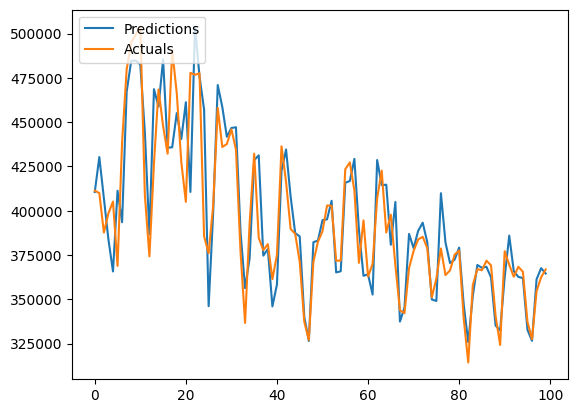

MAPE: 2.94%
RMSE: 16081.31
MAE : 11317.22


Predictions    Actuals
0    410560.18750  411339.27
1    430289.53125  409963.40
2    407043.59375  387672.63
3    383778.84375  398542.65
4    365720.09375  405159.36
..            ...        ...
353  351765.15625  360393.59
354  343498.15625  369325.03
355  381776.25000  371819.56
356  399205.50000  399427.25
357  401826.75000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model19, X_test19, y_test19, 0, 100)

## 6. Inherit Optuna Hyperparameters ##

### Model 17 Re-Run (Optuna Inheritance) ###

In [ ]:
''' N.B. As follow up models, the Optuna optimisation was NOT run, and the
hyperparameter values here were inherited from the runs with the 2016-2019
dataset.  A full investigation with the ful dataset would most likely result in
slightly more optimal results.
'''
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

# Initialise variables for input layer
i = X_train20.shape[1]
j = X_train20.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model20 = create_lstm_model(n_units = 32, dropout = 0.013)

# create model checkpoint
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)

# compile model
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history20 = model20.fit(X_train20, y_train20, epochs=100, batch_size=8, callbacks=[cp20])

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


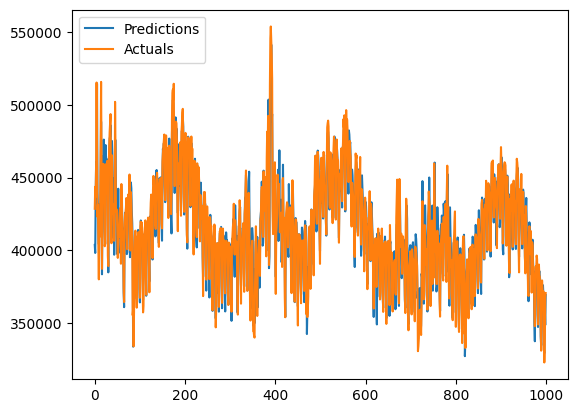

MAPE: 2.34%
RMSE: 13135.53
MAE : 9121.45


Predictions    Actuals
0     403608.28125  428486.93
1     398105.40625  443638.09
2     434722.25000  436849.95
3     460750.12500  460042.56
4     455139.28125  515344.46
...            ...        ...
3275  380962.25000  405457.46
3276  414615.21875  421027.63
3277  381453.96875  407376.71
3278  390950.59375  402263.51
3279  405205.50000  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model20 = load_model('model20.keras')

# print training metrics
predictions_plot(model20, X_train20, y_train20, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


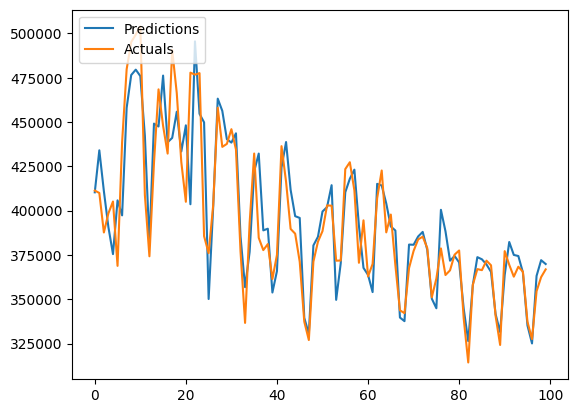

MAPE: 2.86%
RMSE: 15387.26
MAE : 10944.20


Predictions    Actuals
0    410327.68750  411339.27
1    434032.03125  409963.40
2    411001.09375  387672.63
3    390603.21875  398542.65
4    375476.40625  405159.36
..            ...        ...
353  361759.25000  360393.59
354  354584.46875  369325.03
355  380593.06250  371819.56
356  401340.53125  399427.25
357  404712.21875  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model20, X_test20, y_test20, 0, 100)

### Model 17 Re-Run (Optuna Inheritance Run 2) ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

# Initialise variables for input layer
i = X_train21.shape[1]
j = X_train21.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model21 = create_lstm_model(n_units=57, dropout=0.013)

# create model checkpoint
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)

# compile model
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0012, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history21 = model21.fit(X_train21, y_train21, epochs=100, batch_size=32, callbacks=[cp21])

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 57)             │        16,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,661 (65.08 KB)

 Trainable params: 16,661 (65.08 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


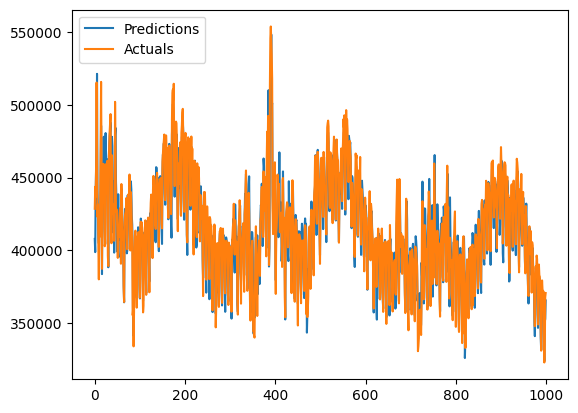

MAPE: 2.32%
RMSE: 12857.41
MAE : 9097.54


Predictions    Actuals
0     407733.12500  428486.93
1     398676.87500  443638.09
2     439149.03125  436849.95
3     455730.40625  460042.56
4     474437.87500  515344.46
...            ...        ...
3275  379931.12500  405457.46
3276  422346.43750  421027.63
3277  397020.43750  407376.71
3278  400258.21875  402263.51
3279  412642.28125  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model21 = load_model('model21.keras')

# print training metrics
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


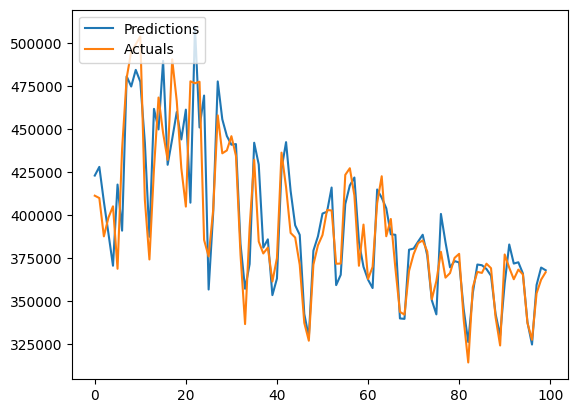

MAPE: 2.86%
RMSE: 15912.69
MAE : 11041.65


Predictions    Actuals
0    423024.28125  411339.27
1    428080.84375  409963.40
2    407861.09375  387672.63
3    389411.84375  398542.65
4    370602.93750  405159.36
..            ...        ...
353  361714.50000  360393.59
354  358498.65625  369325.03
355  382410.03125  371819.56
356  398757.71875  399427.25
357  418540.56250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model21, X_test21, y_test21, 0, 100)

### Model 17 Re-Run (Optuna Inheritance) - Batch Size Adjust ###

In [ ]:
# Test adjustment of batch size (quicker weight updates, slower computation)

# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

# Initialise variables for input layer
i = X_train22.shape[1]
j = X_train22.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model22 = create_lstm_model(n_units=32, dropout=0.013)

# create model checkpoint
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)

# compile model
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history22 = model22.fit(X_train22, y_train22, epochs=100, batch_size=4, callbacks=[cp22])

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


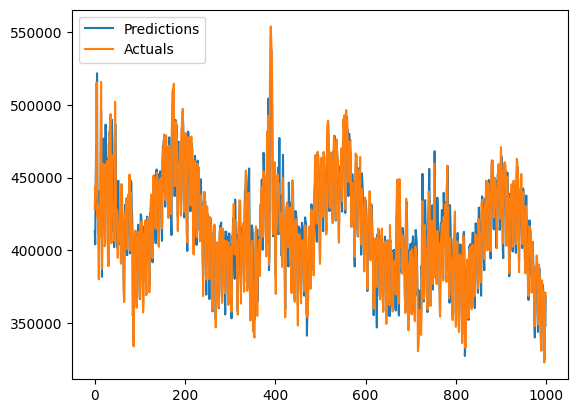

MAPE: 2.39%
RMSE: 13308.82
MAE : 9299.24


Predictions    Actuals
0     413213.12500  428486.93
1     404049.96875  443638.09
2     443228.31250  436849.95
3     471986.21875  460042.56
4     464536.40625  515344.46
...            ...        ...
3275  383676.87500  405457.46
3276  422276.15625  421027.63
3277  390982.28125  407376.71
3278  395612.75000  402263.51
3279  412576.84375  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model22 = load_model('model22.keras')

# print training metrics
predictions_plot(model22, X_train22, y_train22, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


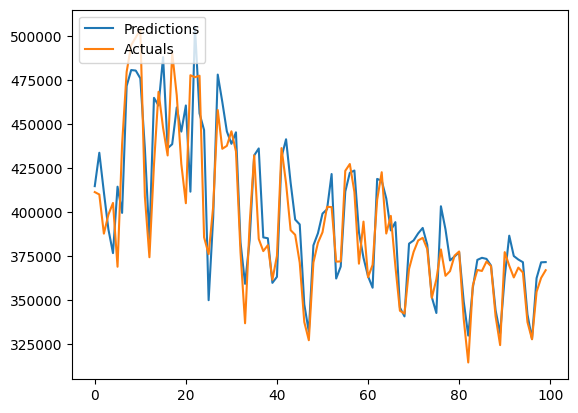

MAPE: 2.88%
RMSE: 15606.94
MAE : 11050.14


Predictions    Actuals
0    414718.37500  411339.27
1    433722.90625  409963.40
2    411289.71875  387672.63
3    390056.25000  398542.65
4    376598.90625  405159.36
..            ...        ...
353  359397.68750  360393.59
354  361350.84375  369325.03
355  380074.93750  371819.56
356  402799.21875  399427.25
357  407614.56250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model22, X_test22, y_test22, 0, 100)

## 7. Architecture Exploration ##

### Stacked LSTM - From Model 20 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

# Initialise variables for input layer
i = X_train23.shape[1]
j = X_train23.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model23 = create_stacked_lstm_model()

# create model checkpoint
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)

# compile model
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=8, callbacks=[cp23])

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 7, 32)          │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,169 (35.82 KB)

 Trainable params: 9,169 (35.82 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


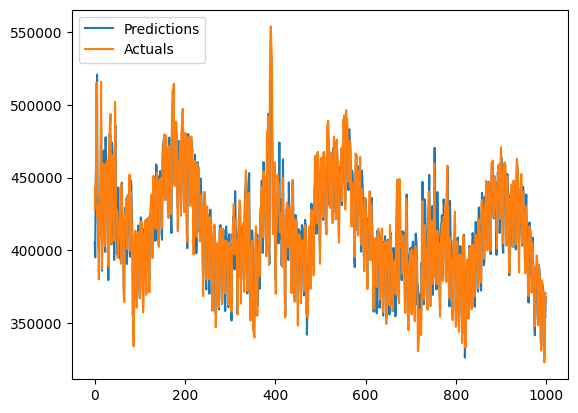

MAPE: 2.38%
RMSE: 13208.56
MAE : 9298.77


Predictions    Actuals
0     405352.43750  428486.93
1     395059.78125  443638.09
2     444441.46875  436849.95
3     461119.78125  460042.56
4     461305.25000  515344.46
...            ...        ...
3275  376211.75000  405457.46
3276  420671.00000  421027.63
3277  388819.71875  407376.71
3278  389382.34375  402263.51
3279  412745.09375  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model23 = load_model('model23.keras')

# print training metrics
predictions_plot(model23, X_train23, y_train23, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


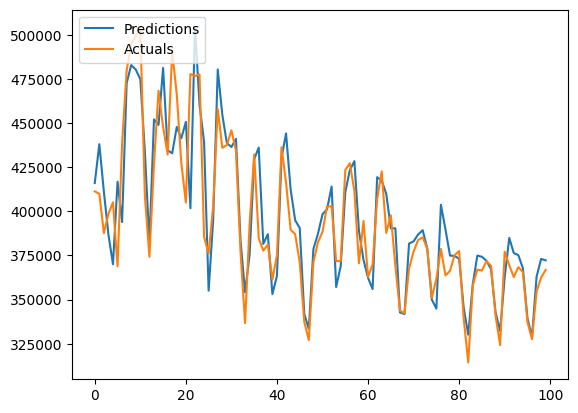

MAPE: 2.96%
RMSE: 15901.84
MAE : 11342.35


Predictions    Actuals
0    416070.96875  411339.27
1    438074.09375  409963.40
2    411145.12500  387672.63
3    386796.18750  398542.65
4    370004.21875  405159.36
..            ...        ...
353  358740.75000  360393.59
354  357386.68750  369325.03
355  378069.34375  371819.56
356  406241.09375  399427.25
357  399449.59375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model23, X_test23, y_test23, 0, 100)

### CNN-LSTM Test - From Model 20 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data24 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train24, y_train24 = data24['train']
X_test24, y_test24 = data24['test']

# Initialise variables for input layer
i = X_train24.shape[1]
j = X_train24.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model24 = create_cnn_lstm_model()

# create model checkpoint
cp24 = ModelCheckpoint('model24.keras', monitor='loss', save_best_only=True)

# compile model
model24.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history24 = model24.fit(X_train24, y_train24, epochs=100, batch_size=8, callbacks=[cp24])

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,249 (59.57 KB)

 Trainable params: 15,249 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


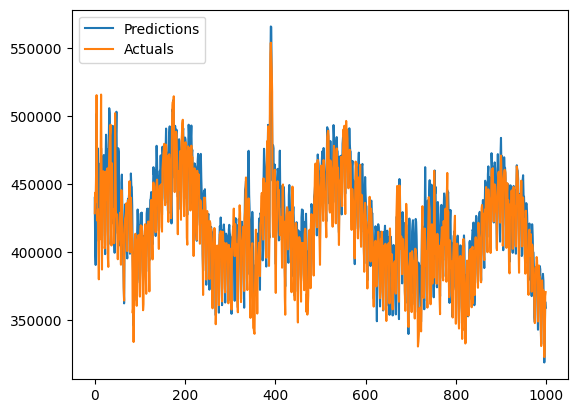

MAPE: 3.29%
RMSE: 17383.97
MAE : 12758.14


Predictions    Actuals
0     439839.68750  428486.93
1     400770.62500  443638.09
2     390498.21875  436849.95
3     463136.18750  460042.56
4     501729.81250  515344.46
...            ...        ...
3275  385426.93750  405457.46
3276  392582.62500  421027.63
3277  391505.37500  407376.71
3278  385476.21875  402263.51
3279  401406.18750  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model24 = load_model('model24.keras')

# print training metrics
predictions_plot(model24, X_train24, y_train24, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


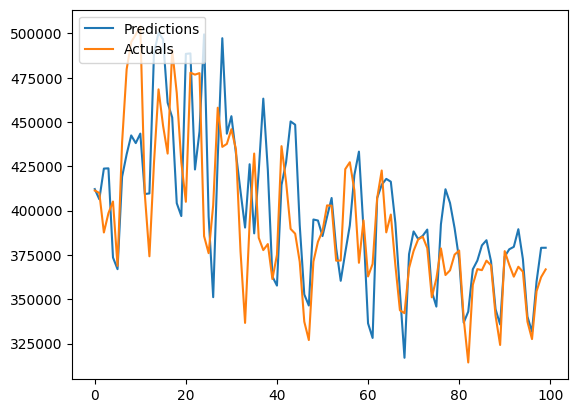

MAPE: 4.91%
RMSE: 25185.62
MAE : 18808.98


Predictions    Actuals
0    412135.15625  411339.27
1    406416.40625  409963.40
2    423728.21875  387672.63
3    423860.18750  398542.65
4    373580.50000  405159.36
..            ...        ...
353  360078.40625  360393.59
354  347472.00000  369325.03
355  378076.25000  371819.56
356  423900.93750  399427.25
357  422622.75000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model24, X_test24, y_test24, 0, 100)

## 8. Final Feature Adjustments ##

### Explore Temp^2 ###

In [ ]:
# Create squared average temperature feature to match exploratory data analysis
seasonsWdWeDemandDF2 = seasonsWdWeDemandDF.copy()
seasonsWdWeDemandDF2['temp2'] = seasonsWdWeDemandDF2['avg_temp']**2
seasonsWdWeDemandDF2.head()


is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2010-01-01            0           1          0          0          1   
2010-01-02            1           0          0          0          1   
2010-01-03            1           0          0          0          1   
2010-01-04            0           1          0          0          1   
2010-01-05            0           1          0          0          1   

             is_autumn  sum_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2010-01-01           0          374464.94  25.094000      22.1      28.8   
2010-01-02           0          384838.07  24.765385      21.6      29.4   
2010-01-03           0          355195.18  19.429825      17.9      21.5   
2010-01-04           0          395602.57  20.625926      17.9      23.9   
2010-01-05           0          423735.03  22.660417      15.4      27.7   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2010-01-01           0.0     5.594000         6.7  629.708836  
2010-01-02           0.0     5.265385         7.8  613.324275  
2010-01-03           0.0     0.000000         3.6  377.518082  
2010-01-04           0.0     1.125926         6.0  425.428820  
2010-01-05           0.0     3.160417        12.3  513.494484

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data25 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train25, y_train25 = data25['train']
X_test25, y_test25 = data25['test']

# Initialise variables for input layer
i = X_train25.shape[1]
j = X_train25.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model25 = create_lstm_model(n_units=32, dropout=0.013)

# create model checkpoint
cp25 = ModelCheckpoint('model25.keras', monitor='loss', save_best_only=True)

# compile model
model25.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history25 = model25.fit(X_train25, y_train25, epochs=100, batch_size=8, callbacks=[cp25])

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


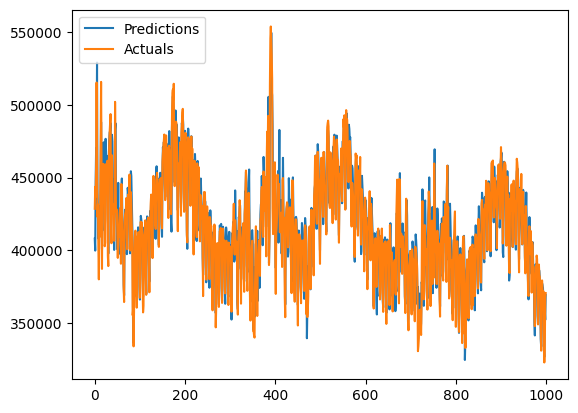

MAPE: 2.45%
RMSE: 13665.46
MAE : 9514.33


Predictions    Actuals
0     407942.18750  428486.93
1     399728.81250  443638.09
2     447155.18750  436849.95
3     470337.46875  460042.56
4     466045.68750  515344.46
...            ...        ...
3275  377286.84375  405457.46
3276  412805.18750  421027.63
3277  385591.78125  407376.71
3278  399387.93750  402263.51
3279  421225.96875  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model25 = load_model('model25.keras')

# print training metrics
predictions_plot(model25, X_train25, y_train25, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


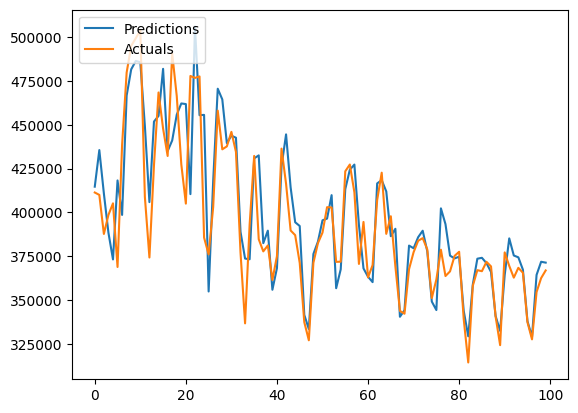

MAPE: 3.01%
RMSE: 16385.60
MAE : 11498.16


Predictions    Actuals
0    414659.62500  411339.27
1    435546.59375  409963.40
2    410784.00000  387672.63
3    388404.68750  398542.65
4    373146.00000  405159.36
..            ...        ...
353  364605.28125  360393.59
354  358079.18750  369325.03
355  385847.62500  371819.56
356  404890.15625  399427.25
357  411183.00000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model25, X_test25, y_test25, 0, 100)

### Explore Recurrent Dropout ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data26 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train26, y_train26 = data26['train']
X_test26, y_test26 = data26['test']

# Initialise variables for input layer
i = X_train26.shape[1]
j = X_train26.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model26 = create_lstm_model(n_units=32, dropout=0.013, recurrent_dropout=0.013)

# create model checkpoint
cp26 = ModelCheckpoint('model26.keras', monitor='loss', save_best_only=True)

# compile model
model26.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history26 = model26.fit(X_train26, y_train26, epochs=100, batch_size=8, callbacks=[cp26])

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


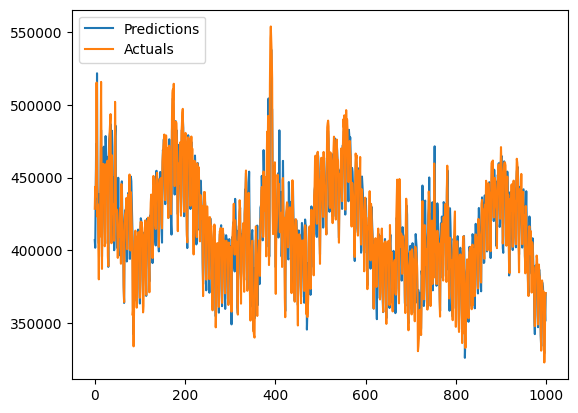

MAPE: 2.45%
RMSE: 13659.99
MAE : 9532.87


Predictions    Actuals
0     407001.65625  428486.93
1     401686.56250  443638.09
2     432772.65625  436849.95
3     473132.78125  460042.56
4     459565.06250  515344.46
...            ...        ...
3275  378881.71875  405457.46
3276  413667.84375  421027.63
3277  386498.00000  407376.71
3278  395673.68750  402263.51
3279  420097.40625  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model26 = load_model('model26.keras')

# print training metrics
predictions_plot(model26, X_train26, y_train26, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


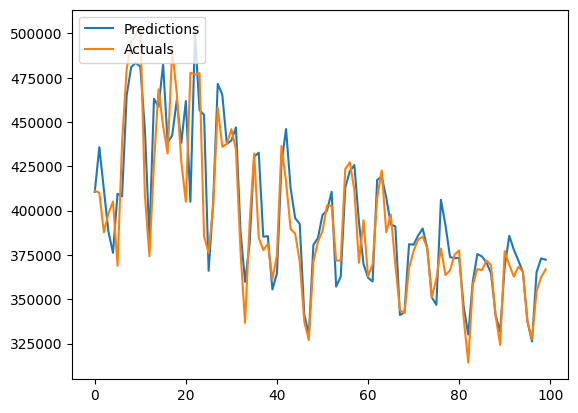

MAPE: 2.95%
RMSE: 15914.51
MAE : 11285.46


Predictions    Actuals
0    410633.15625  411339.27
1    435810.53125  409963.40
2    411837.00000  387672.63
3    388085.53125  398542.65
4    376205.78125  405159.36
..            ...        ...
353  357358.71875  360393.59
354  352726.21875  369325.03
355  383603.50000  371819.56
356  411357.31250  399427.25
357  408451.87500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model26, X_test26, y_test26, 0, 100)

### Temp^2/Recurrent Dropout (Post Optuna) ###

In [ ]:
''' N.B. As with the previous post optuna models, the Optuna optimisation was
NOT run, and the hyperparameter values here were inherited from the runs with
the 2016-2019 dataset.  A full investigation with the ful dataset would most
likely result in slightly more optimal results.
'''
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data27 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train27, y_train27 = data27['train']
X_test27, y_test27 = data27['test']

# Initialise variables for input layer
i = X_train27.shape[1]
j = X_train27.shape[2]

7


In [ ]:
# set seed
reset_seed()

# create model
model27 = create_lstm_model(n_units=64, dropout=0.00145, recurrent_dropout=0.3)

# create model checkpoint
cp27 = ModelCheckpoint('model27.keras', monitor='loss', save_best_only=True)

# compile model
model27.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history27 = model27.fit(X_train27, y_train27, epochs=100, batch_size=32, callbacks=[cp27])

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


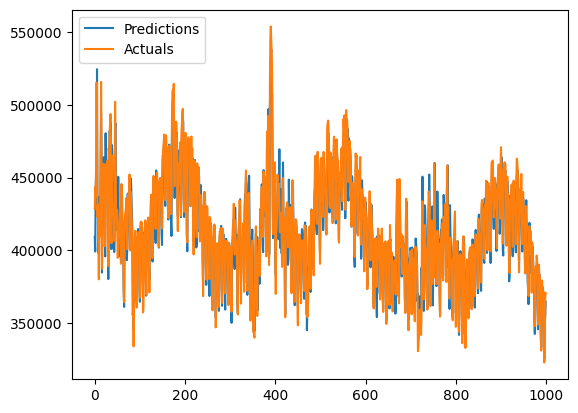

MAPE: 2.21%
RMSE: 12293.59
MAE : 8675.19


Predictions    Actuals
0     409130.56250  428486.93
1     399089.00000  443638.09
2     440716.93750  436849.95
3     454875.40625  460042.56
4     462846.93750  515344.46
...            ...        ...
3275  380533.06250  405457.46
3276  425807.03125  421027.63
3277  391882.31250  407376.71
3278  412823.28125  402263.51
3279  401245.18750  405023.08

[3280 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model27 = load_model('model30.keras')

# print training metrics
predictions_plot(model27, X_train27, y_train27, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


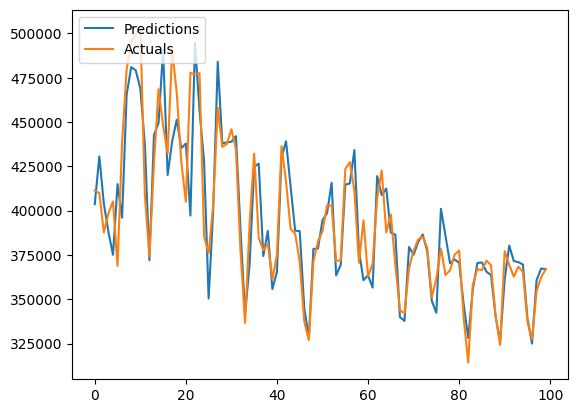

MAPE: 2.74%
RMSE: 15293.35
MAE : 10540.12


Predictions    Actuals
0    403649.40625  411339.27
1    430604.81250  409963.40
2    403755.53125  387672.63
3    388046.65625  398542.65
4    375097.71875  405159.36
..            ...        ...
353  360415.65625  360393.59
354  356218.25000  369325.03
355  392788.43750  371819.56
356  409916.78125  399427.25
357  398287.12500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model27, X_test27, y_test27, 0, 100)